In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import comet_ml
from comet_ml import Experiment

In [3]:
import os, sys
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CometLogger

In [4]:
sys.path.insert(0,'../training')
from manifoldembedder import *
from sklearn.manifold import TSNE
import umap 

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon
import matplotlib
from matplotlib.patches import ConnectionPatch
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 18})

In [6]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt


In [7]:
rawjetdir = '/nobackup/users/sangeon/datasets/jetGridpack/rawjets/'
type_arr  = [['QCD','QCD',''],['2p','twoprong','_80'],['2p','twoprong','_400'],['3p','threeprong','_80'],['3p','threeprong','_400'],['4p','fourprong','_170'],['4p','fourprong','_400']]
set_list = []
name_list = ['QCD','2p80','2p400','3p80','3p400','4p170','4p400']

results = np.empty((0,54))
predict_label = np.empty((0))
#extrafeats = np.empty((0,14))

for i, (name, jettype) in enumerate(zip(name_list, type_arr)):
    df = pd.read_hdf(os.path.join(rawjetdir,jettype[0],f'{jettype[1]}{jettype[2]}.h5'))
    data = df.values[:,:54]
    feats = df.values[:,48:]
    print(data.shape)
    print(feats.shape)
    data = data[0:3000]
    feats = feats[0:3000]
    #extrafeats = np.vstack([extrafeats, feats])
    results = np.vstack([results, data])
    print(df.values.shape[0])
    print(name, jettype)
    predict_label = np.concatenate([predict_label, np.repeat(i, data.shape[0])])

(1947882, 54)
(1947882, 6)
1947882
QCD ['QCD', 'QCD', '']
(1754310, 54)
(1754310, 6)
1754310
2p80 ['2p', 'twoprong', '_80']
(1345592, 54)
(1345592, 6)
1345592
2p400 ['2p', 'twoprong', '_400']
(2508209, 54)
(2508209, 6)
2508209
3p80 ['3p', 'threeprong', '_80']
(1382312, 54)
(1382312, 6)
1382312
3p400 ['3p', 'threeprong', '_400']
(207456, 54)
(207456, 6)
207456
4p170 ['4p', 'fourprong', '_170']
(187644, 54)
(187644, 6)
187644
4p400 ['4p', 'fourprong', '_400']


In [8]:
results.shape

(21000, 54)

In [9]:
import time

In [10]:
results.shape

(21000, 54)

In [ ]:
savedir   = '/nobackup/users/sangeon/datasets/jetGridpack/jetpairs/applestoapples/'
#rawjetdir = '/nobackup/users/sangeon/datasets/jetGridpack/rawjets/'
#type_arr  = [['QCD','QCD',''],['2p','twoprong','_80'],['2p','twoprong','_400'],['3p','threeprong','_80'],['3p','threeprong','_400']]
len_train = 21000
len_half  = 10500
start = time.time()
for i in range(3000,4000):
    np.random.seed()
    #type_1 = type_arr[np.random.randint(0,5)]
    np.random.seed()
    #type_2 = type_arr[np.random.randint(0,5)]

    
    #df1 = pd.read_hdf(os.path.join(rawjetdir,type_1[0],f'{type_1[1]}{type_1[2]}.h5'))
    #df2 = pd.read_hdf(os.path.join(rawjetdir,type_2[0],f'{type_2[1]}{type_2[2]}.h5'))
    #A = df1.values
    #B = df2.values
    
    np.random.seed()
    perm = np.random.permutation(len_train)
    #print(A[perm[:5000]].shape)
    #print(B[perm[5000:]].shape)
    #print(os.path.join(rawjetdir,type_1[0],f'{type_1[1]}{type_1[2]}.h5'))
    #print(os.path.join(rawjetdir,type_2[0],f'{type_2[1]}{type_2[2]}.h5'))
    
    train_set = JetDataset(False, None, False, results[perm[:len_half]],results[perm[len_half:]],16)
    torch.save(train_set, os.path.join(savedir,f'apples_to_apples_train_{i}.pt'))
    
end = time.time()
print('total time', end-start)

  0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
predict_label

array([0., 0., 0., ..., 6., 6., 6.])

In [15]:
results.shape

(21000, 54)

In [16]:
#predict_set = JetPredictDataset(False,None,False, results,predict_label,16)
#torch.save(predict_set, f'/nobackup/users/sangeon/datasets/jetGridpack/jetpairs/applestoapples/Gridpack_jetpair_applestoapples_predict.pt')

In [9]:
train_file_list = []
basedir  = '/nobackup/users/sangeon/datasets/jetGridpack/jetpairs/applestoapples/'
for file in os.listdir(basedir):
    if "train" in file:
        train_file_list.append(os.path.join(basedir,file))


In [10]:
#train_list = []
#for file in train_file_list:
#    train_list.append(torch.load(file))
#jet_train = torch.utils.data.ConcatDataset(train_list)
#torch.save(jet_train, os.path.join(basedir, 'applestoapples_merge_16part.pt'))

In [11]:
file_dict = {'train':os.path.join(basedir, 'applestoapples_merge_16part.pt'),
             'val':os.path.join(basedir, 'applestoapples_merge_16part.pt'),
             'test':None,
             'predict':os.path.join(basedir, 'Gridpack_jetpair_applestoapples_predict.pt')}

In [12]:
jet_dm = JetDataModule(file_dict,2000)
model = ManifoldEmbedder("jets",2,"Transformer", 0.00054607179632484, [32, 4, 2, 2, 2, 16, 0.22,0.22, [800,300,30]])

In [13]:
# Create an experiment with your api key
experiment = Experiment(
    api_key="CkkrVkSk6Vr2WKlbXIzlkhNlE",
    project_name="metricembedder",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sangeonpark/metricembedder/49786c41e7a74a0abc3e3c8c9618e32f



In [14]:
comet_logger = CometLogger(
    api_key="CkkrVkSk6Vr2WKlbXIzlkhNlE",
    project_name="metricembedder",
)

CometLogger will be initialized in online mode


In [15]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=20, verbose=False)

In [16]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="/home/sangeon/ToyJetGenerator/analysis/applestoapples_checkpoints",
    filename="Transformer-paper-applestoapples4-checkpoint-{epoch:02d}-{val_loss:.2f}",
    save_top_k=4,
    mode="min",
)

In [17]:
trainer = Trainer(gpus=1,callbacks=[PrintCallbacks(),early_stop_callback,checkpoint_callback],logger=comet_logger,auto_lr_find=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Starting to init trainer!
Trainer is init now


In [18]:
lr_finder = trainer.tuner.lr_find(model, jet_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /home/sangeon/ToyJetGenerator/analysis/lr_find_temp_model_3a6069ad-17f7-4c13-81fc-34a0da2764f5.ckpt


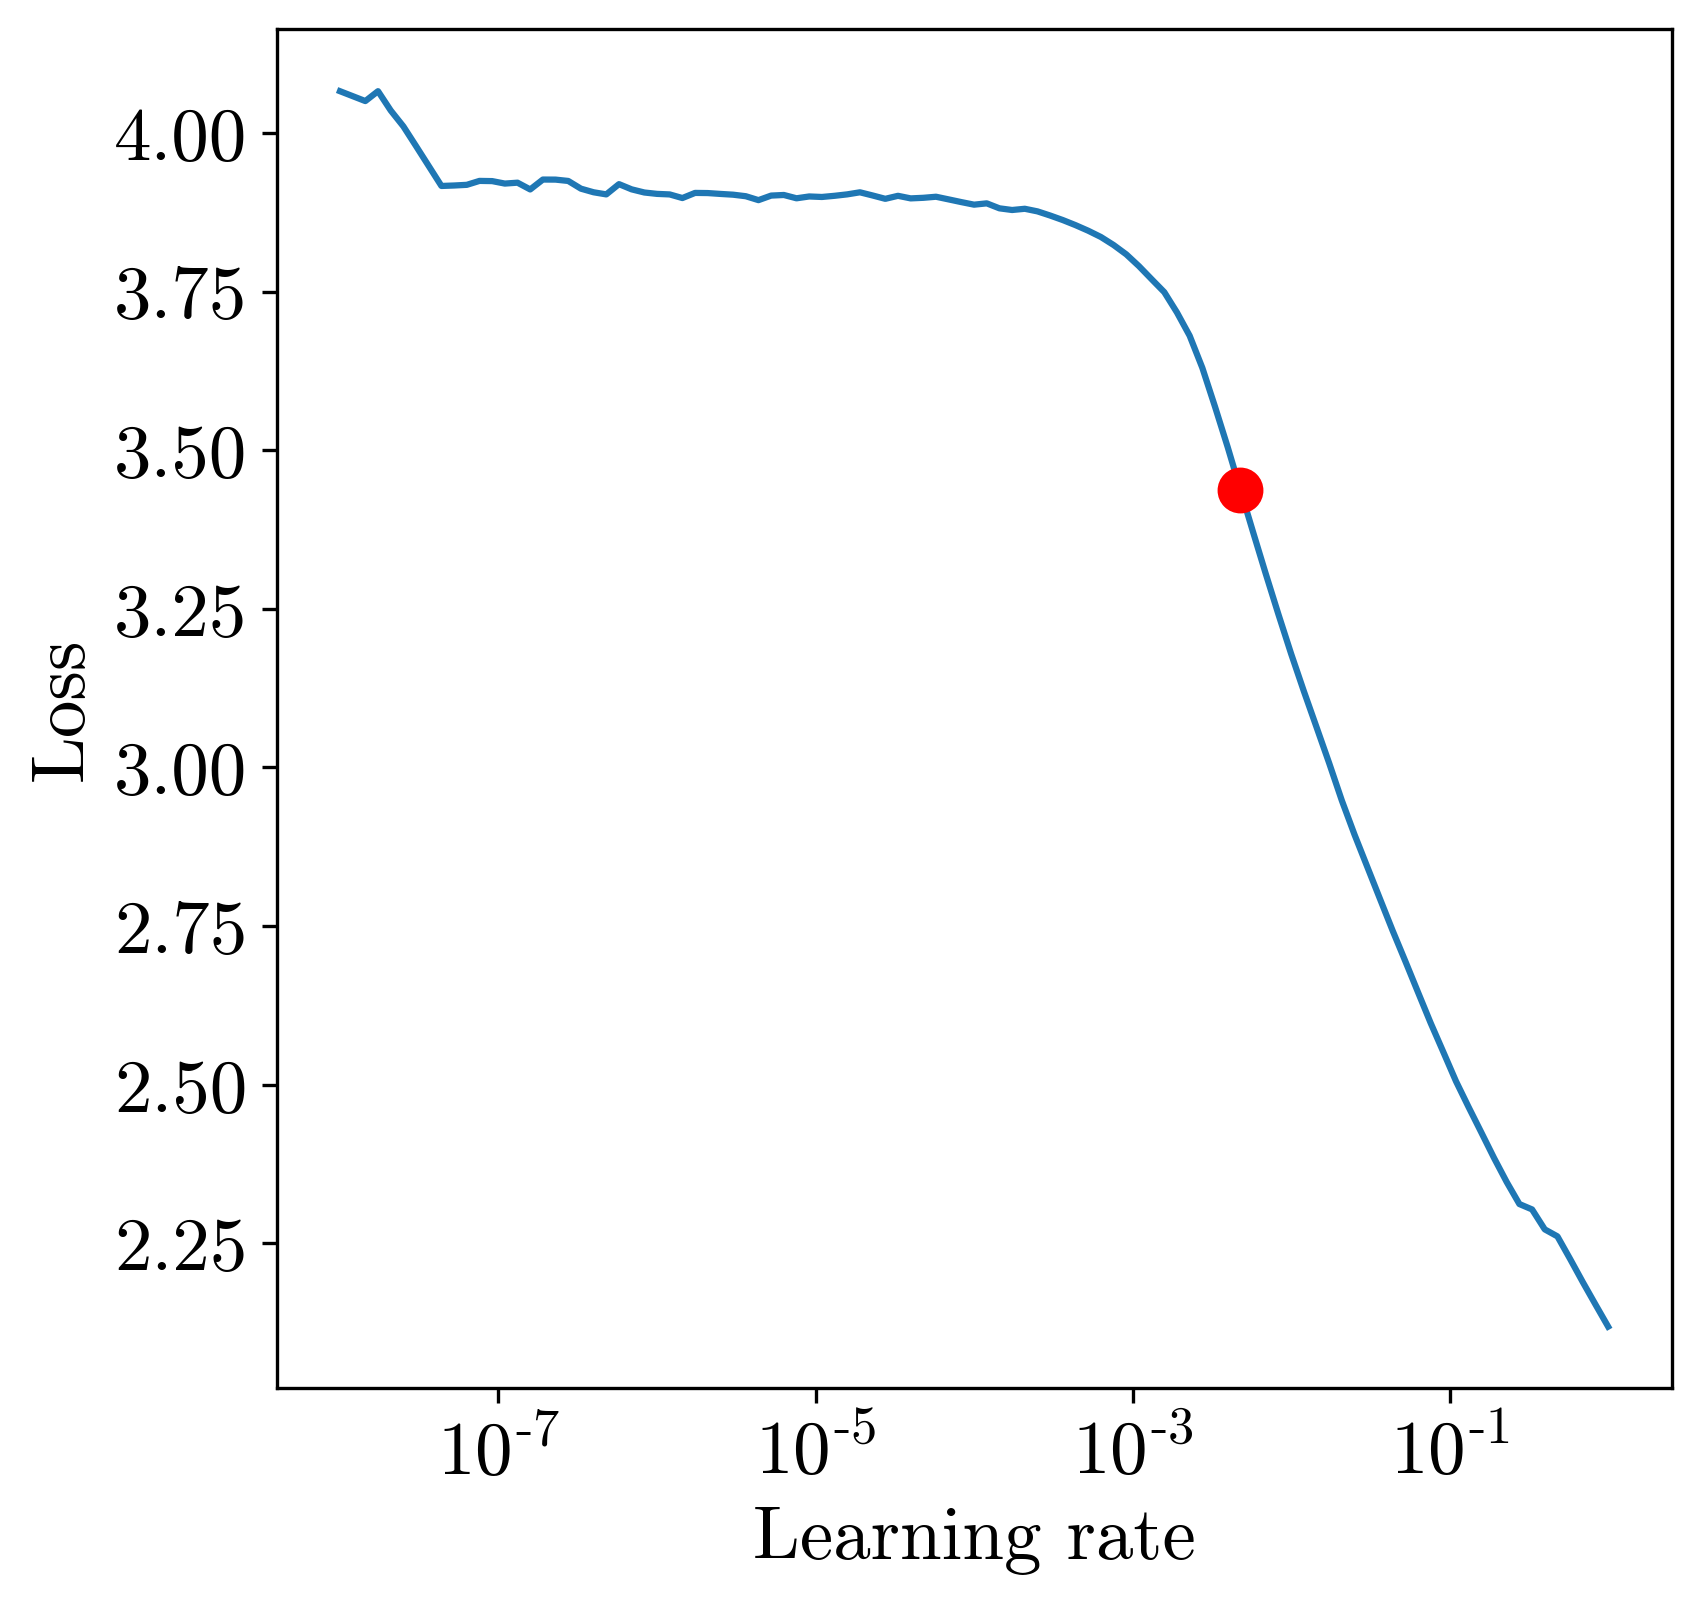

In [19]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [20]:
new_lr = lr_finder.suggestion()

new_lr

model.hparams.learning_rate = new_lr

model.learning_rate = new_lr

model.learning_rate

0.00478630092322638

In [21]:
trainer.fit(model, jet_dm)

/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/sangeonpark/metricembedder/49786c41e7a74a0abc3e3c8c9618e32f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [20] : (0.6437819004058838, 4.126185894012451)
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (5.99 MB)
COMET INFO:  

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validating: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
rawjetdir = '/nobackup/users/sangeon/datasets/jetGridpack/rawjets/'
type_arr  = [['QCD/with_taus','QCD',''],['2p/with_taus','twoprong','_25'],['2p/with_taus','twoprong','_170'],['3p/with_taus','threeprong','_25'],['3p/with_taus','threeprong','_170'],['4p/with_taus','fourprong','_170'],['4p/with_taus','fourprong','_400']]
set_list = []
name_list = ['QCD','2p25','2p170','3p25','3p170','4p170','4p400']

results = np.empty((0,54))
predict_label = np.empty((0))
extrafeats = np.empty((0,14))

for i, (name, jettype) in enumerate(zip(name_list, type_arr)):
    df = pd.read_hdf(os.path.join(rawjetdir,jettype[0],f'{jettype[1]}{jettype[2]}.h5'))
    data = df.values[:,:54]
    feats = df.values[:,48:]
    print(data.shape)
    print(feats.shape)
    data = data[5000:8000]
    feats = feats[5000:8000]
    extrafeats = np.vstack([extrafeats, feats])
    results = np.vstack([results, data])
    print(df.values.shape[0])
    print(name, jettype)
    predict_label = np.concatenate([predict_label, np.repeat(i, data.shape[0])])

(1951762, 54)
(1951762, 14)
1951762
QCD ['QCD/with_taus', 'QCD', '']
(922324, 54)
(922324, 14)
922324
2p25 ['2p/with_taus', 'twoprong', '_25']
(803501, 54)
(803501, 14)
803501
2p170 ['2p/with_taus', 'twoprong', '_170']
(318466, 54)
(318466, 14)
318466
3p25 ['3p/with_taus', 'threeprong', '_25']
(278615, 54)
(278615, 14)
278615
3p170 ['3p/with_taus', 'threeprong', '_170']
(153516, 54)
(153516, 14)
153516
4p170 ['4p/with_taus', 'fourprong', '_170']
(127011, 54)
(127011, 14)
127011
4p400 ['4p/with_taus', 'fourprong', '_400']


In [8]:
extrafeats.shape

(21000, 14)

In [9]:
results.shape

(21000, 54)

In [10]:
tsne = TSNE(n_components=2, random_state=0)

In [11]:
X_2d = tsne.fit_transform(results)

/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [12]:
plt.rcParams["figure.figsize"] = (6.17,6)
plt.rcParams.update({'font.size': 18})

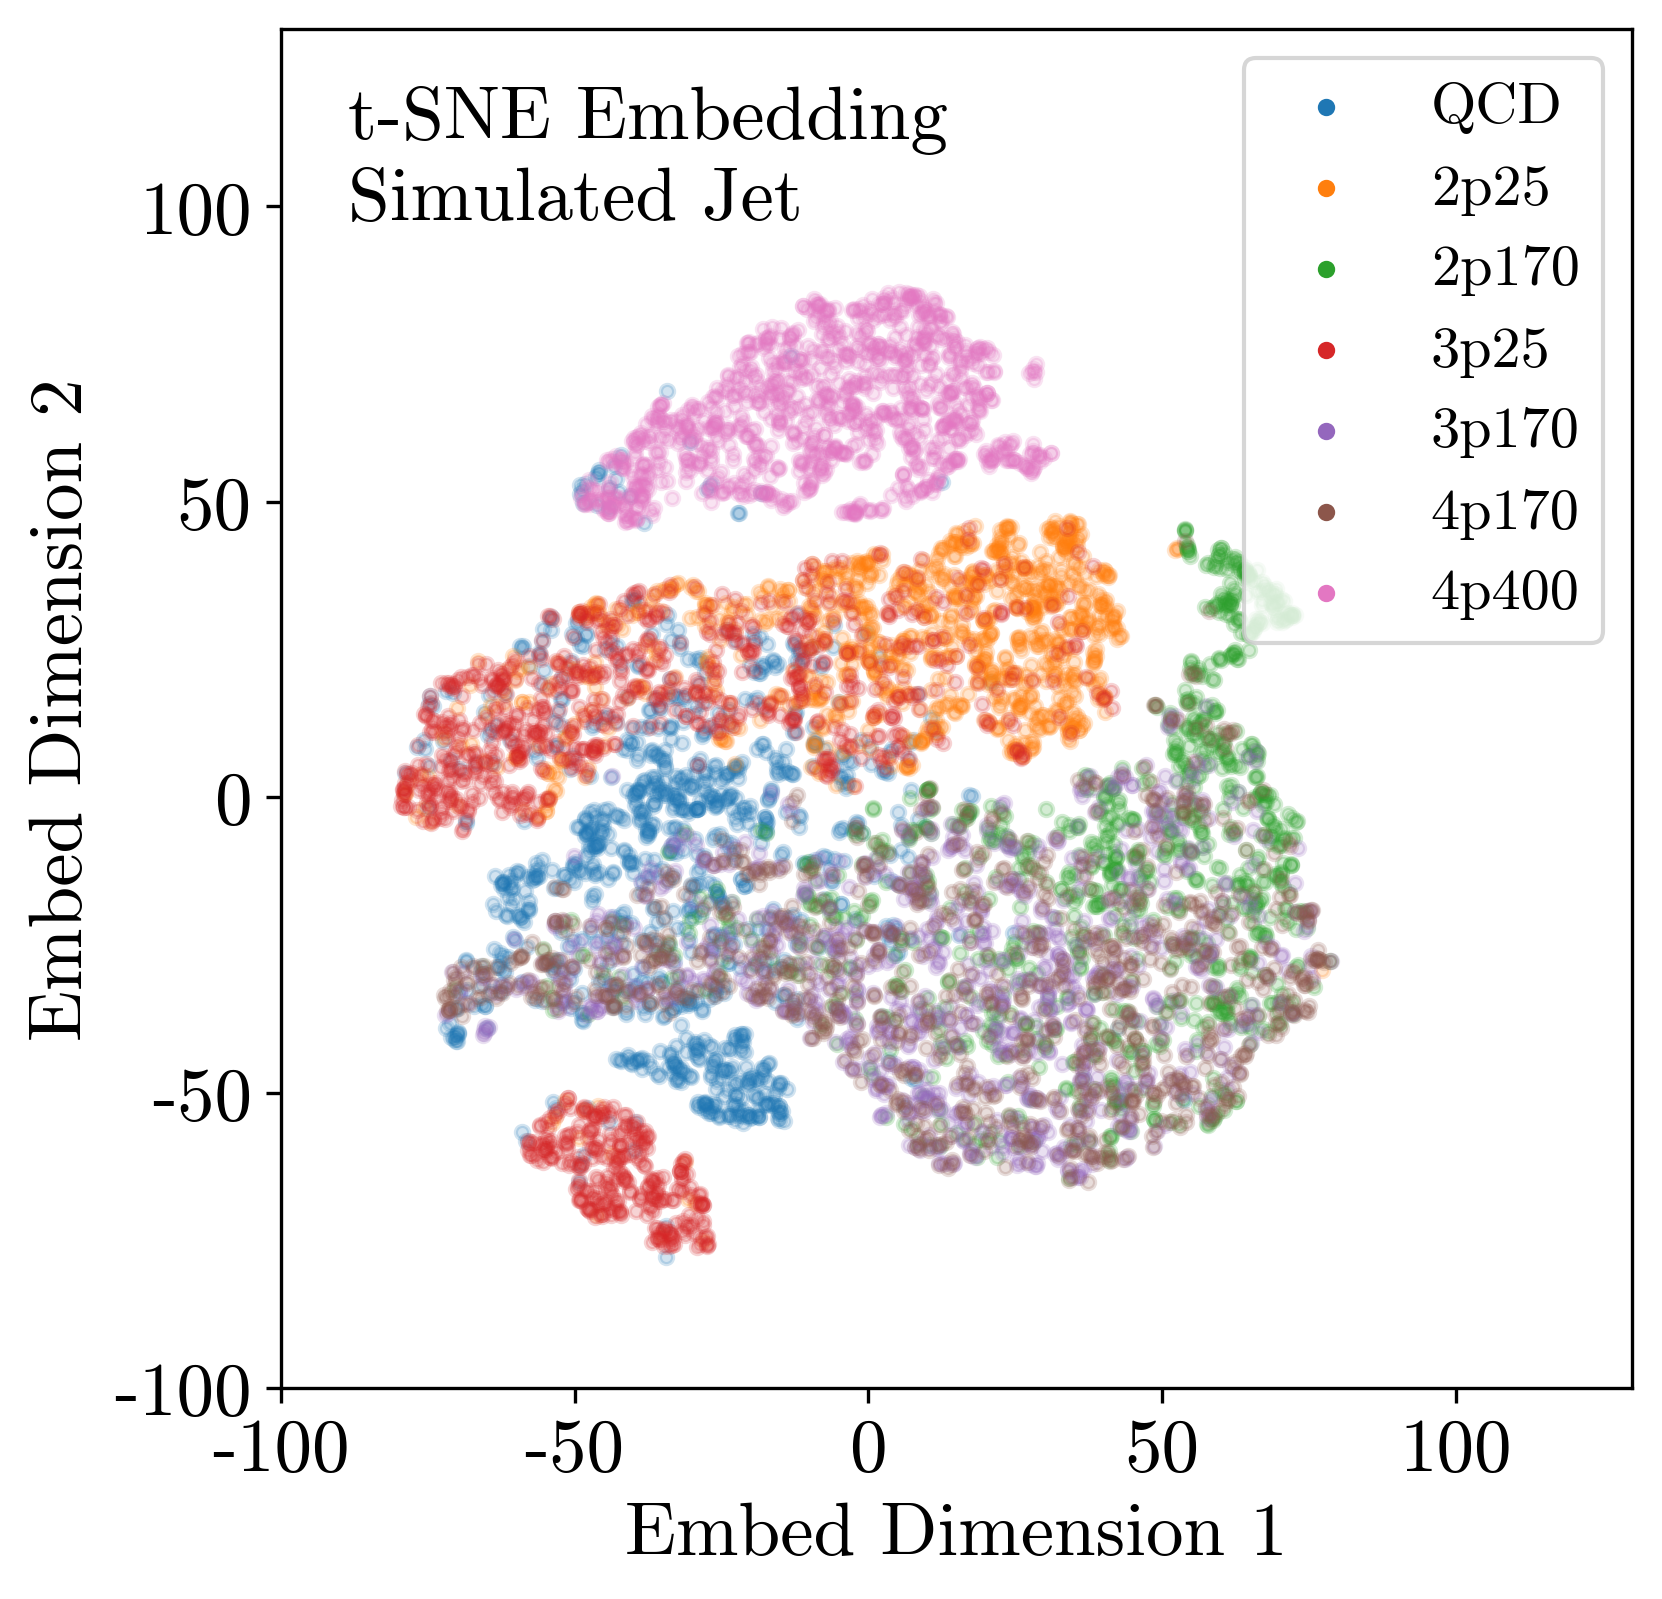

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i in range(7):
    ax.scatter(X_2d[predict_label==i][:1000,0],X_2d[predict_label==i][:1000,1],s=10,alpha=0.20,label=name_list[i])

ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim([-100,130])
ax.set_ylim([-100,130])
leg = ax.legend(fontsize=14)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
ax.text(.05,.92, 't-SNE Embedding',transform=ax.transAxes)    
ax.text(.05,.86, 'Simulated Jet',transform=ax.transAxes)    
plt.subplots_adjust(left=0.17)
#ax.set_title('t-SNE Embedding')    
fig.savefig(f'../figures/paper_JHEP/t-SNE_SimulatedJet_ScatterPlot.png')    
fig.savefig(f'../figures/paper_JHEP/t-SNE_SimulatedJet_ScatterPlot.pdf')

In [15]:
from sklearn.neighbors import KernelDensity
from scipy import interpolate

def kde2D(x, y, xrange, yrange, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""
    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[xrange[0]:xrange[1]:xbins, 
                      yrange[0]:yrange[1]:ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

In [16]:
def plot_KDE_cdf_contour(ax, embedding, label, whichlabel, xrange, yrange, bandwidth, cdfval, color):

    xx, yy, zz = kde2D(embedding[label==whichlabel][:,0], embedding[label==whichlabel][:,1], xrange, yrange, bandwidth= bandwidth, kernel='gaussian')
    hist = zz/zz.sum()
    n = 1000
    t = np.linspace(0, hist.max(), n)
    integral = ((hist >= t[:, None, None]) * hist).sum(axis=(1,2))
    f = interpolate.interp1d(integral, t)

    t_contours = f(np.array(cdfval))
    
    #ax.imshow(hist.T, origin='lower', extent=[-0.1, 0.4, -0.05, 0.35], cmap="gray",aspect='auto')
    CS = ax.contour(hist.T, t_contours, extent=[xrange[0],xrange[1], yrange[0],yrange[1]],colors=color, alpha=0.8)
    
    #fig.set_size_inches(8, 8)
    return CS
    

In [17]:
namelist = name_list

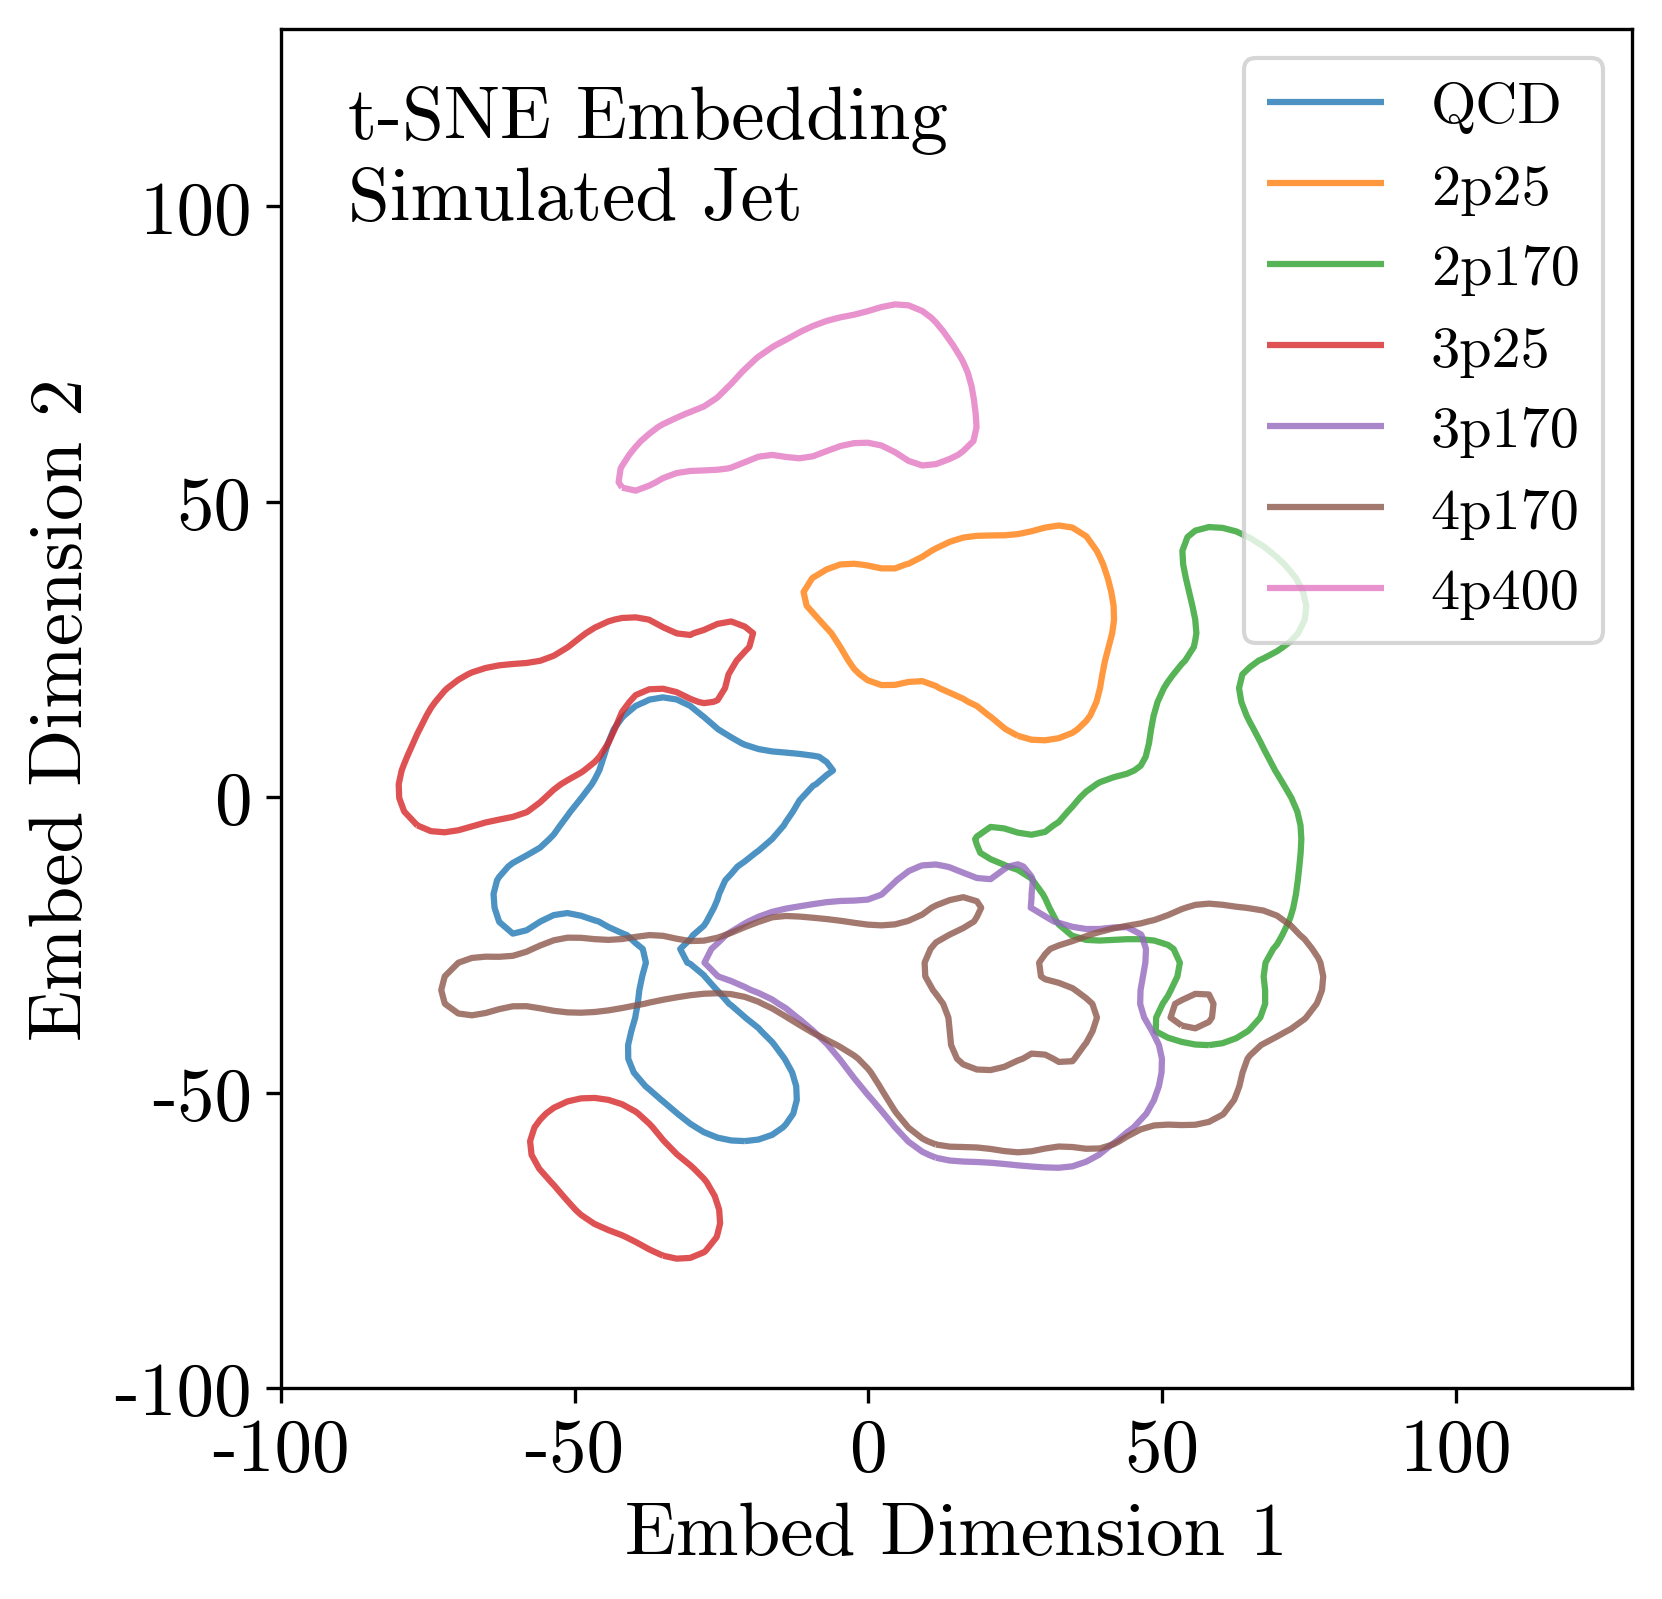

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
lines = []
xrange = [-100,130]
yrange = [-100,130]
for i in range(0,7):
    CS = plot_KDE_cdf_contour(ax, X_2d, predict_label, i, xrange, yrange, 5, [0.5], f'C{i}')
    lines.append(CS.collections[0])


ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.legend(lines, namelist, fontsize=14)
#ax.set_title('Simulated Jet Embedding')    
ax.text(.05,.92, 't-SNE Embedding',transform=ax.transAxes)    
ax.text(.05,.86, 'Simulated Jet',transform=ax.transAxes)    
plt.subplots_adjust(left=0.17)

fig.savefig(f'../figures/paper_JHEP/t-SNE_SimulatedJet_ContourPlot.png')    
fig.savefig(f'../figures/paper_JHEP/t-SNE_SimulatedJet_ContourPlot.pdf')









In [20]:

%time X_2d = tsne.fit_transform(results[:,:48])

/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 7min 32s, sys: 1.7 s, total: 7min 33s
Wall time: 2min 33s


In [13]:
predict_label

array([0., 0., 0., ..., 6., 6., 6.])

In [24]:
X_2d

array([[-14.871328 , -72.67972  ],
       [ -6.0803695, -27.721329 ],
       [  3.2844195, -60.29999  ],
       ...,
       [ 89.22204  ,  32.016056 ],
       [-43.854023 , -30.90524  ],
       [-52.369404 , -42.194073 ]], dtype=float32)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 7000 but corresponding boolean dimension is 700000

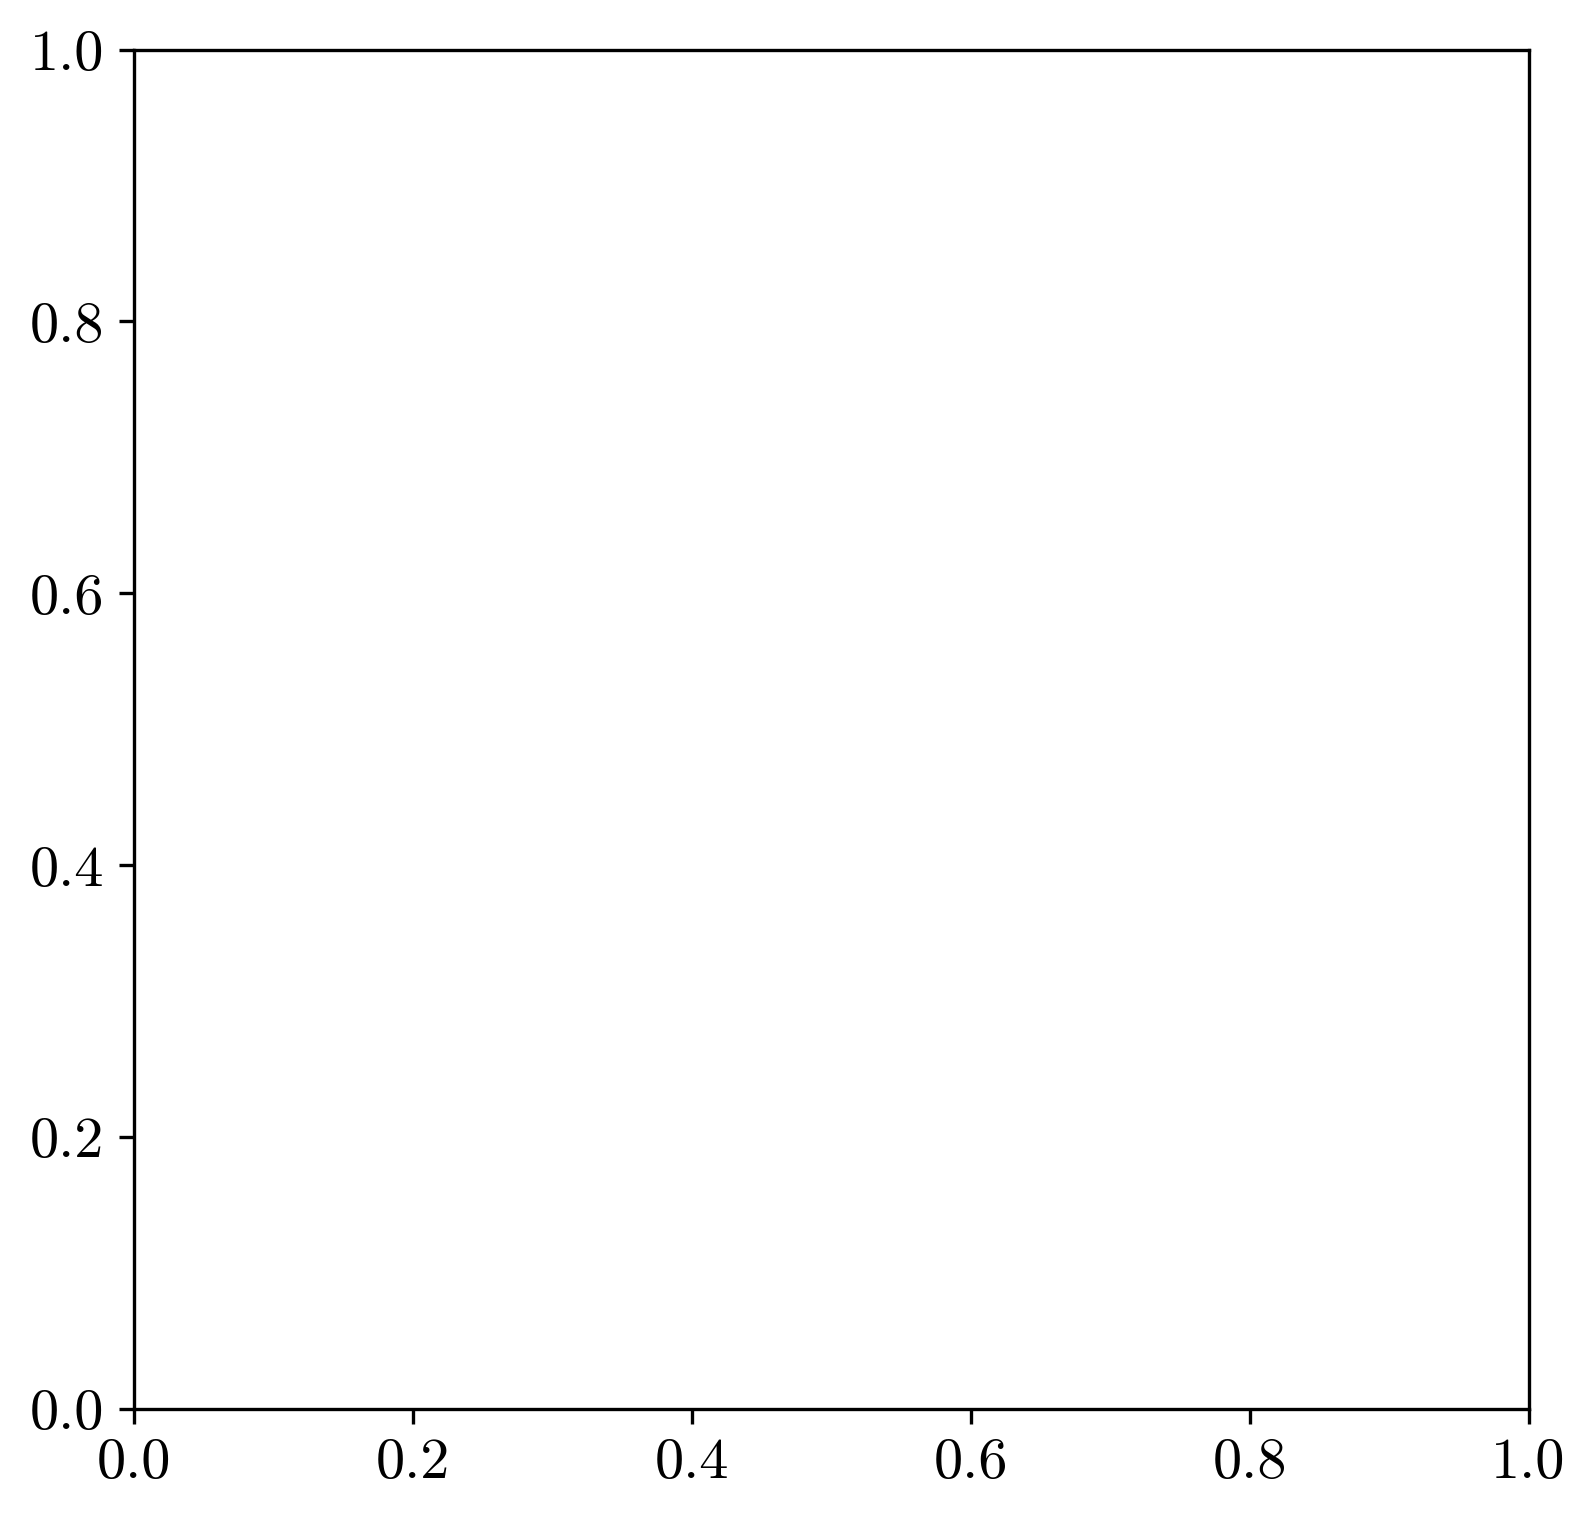

In [59]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i in range(7):
    ax.scatter(X_2d[predict_label==i][:1000,0],X_2d[predict_label==i][:1000,1],s=10,alpha=0.20,label=name_list[i])

ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim([-100,120])
ax.set_ylim([-100,150])
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
ax.text(.05,.92, 'Simulated Jet t-SNE Embedding',transform=ax.transAxes)    

#ax.set_title('t-SNE Embedding')    
#fig.savefig(f'../figures/paper_JHEP/t-SNE_SimulatedJet_ScatterPlot.png')    
#fig.savefig(f'../figures/paper_JHEP/t-SNE_SimulatedJet_ScatterPlot.pdf')

In [174]:
from scipy import stats

def plot_kde(ax, embedding, label, xrange, yrange, npoints, whichlabel, color):
    #xmin = embedding[label==whichlabel][:,0].min()
    #xmax = embedding[label==whichlabel][:,0].max()
    #ymin = embedding[label==whichlabel][:,1].min()
    #ymax = embedding[label==whichlabel][:,1].max()
    xmin, xmax = xrange
    ymin, ymax = yrange
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    kernel = stats.gaussian_kde(embedding[label==whichlabel][:npoints].T)
    Z = np.reshape(kernel(positions).T, X.shape)
    Z /= Z.max()
    print(Z.max(),Z.min())
    #ax.imshow(np.rot90(Z),cmap='Blues' , extent=[xmin, xmax, ymin, ymax])
    CS = ax.contour(X,Y,Z,levels=[0.5],colors=color, alpha=0.8)
    #ax.contour(X,Y,Z,levels=1,colors=color)
    return CS


IndexError: boolean index did not match indexed array along dimension 0; dimension is 21000 but corresponding boolean dimension is 700000

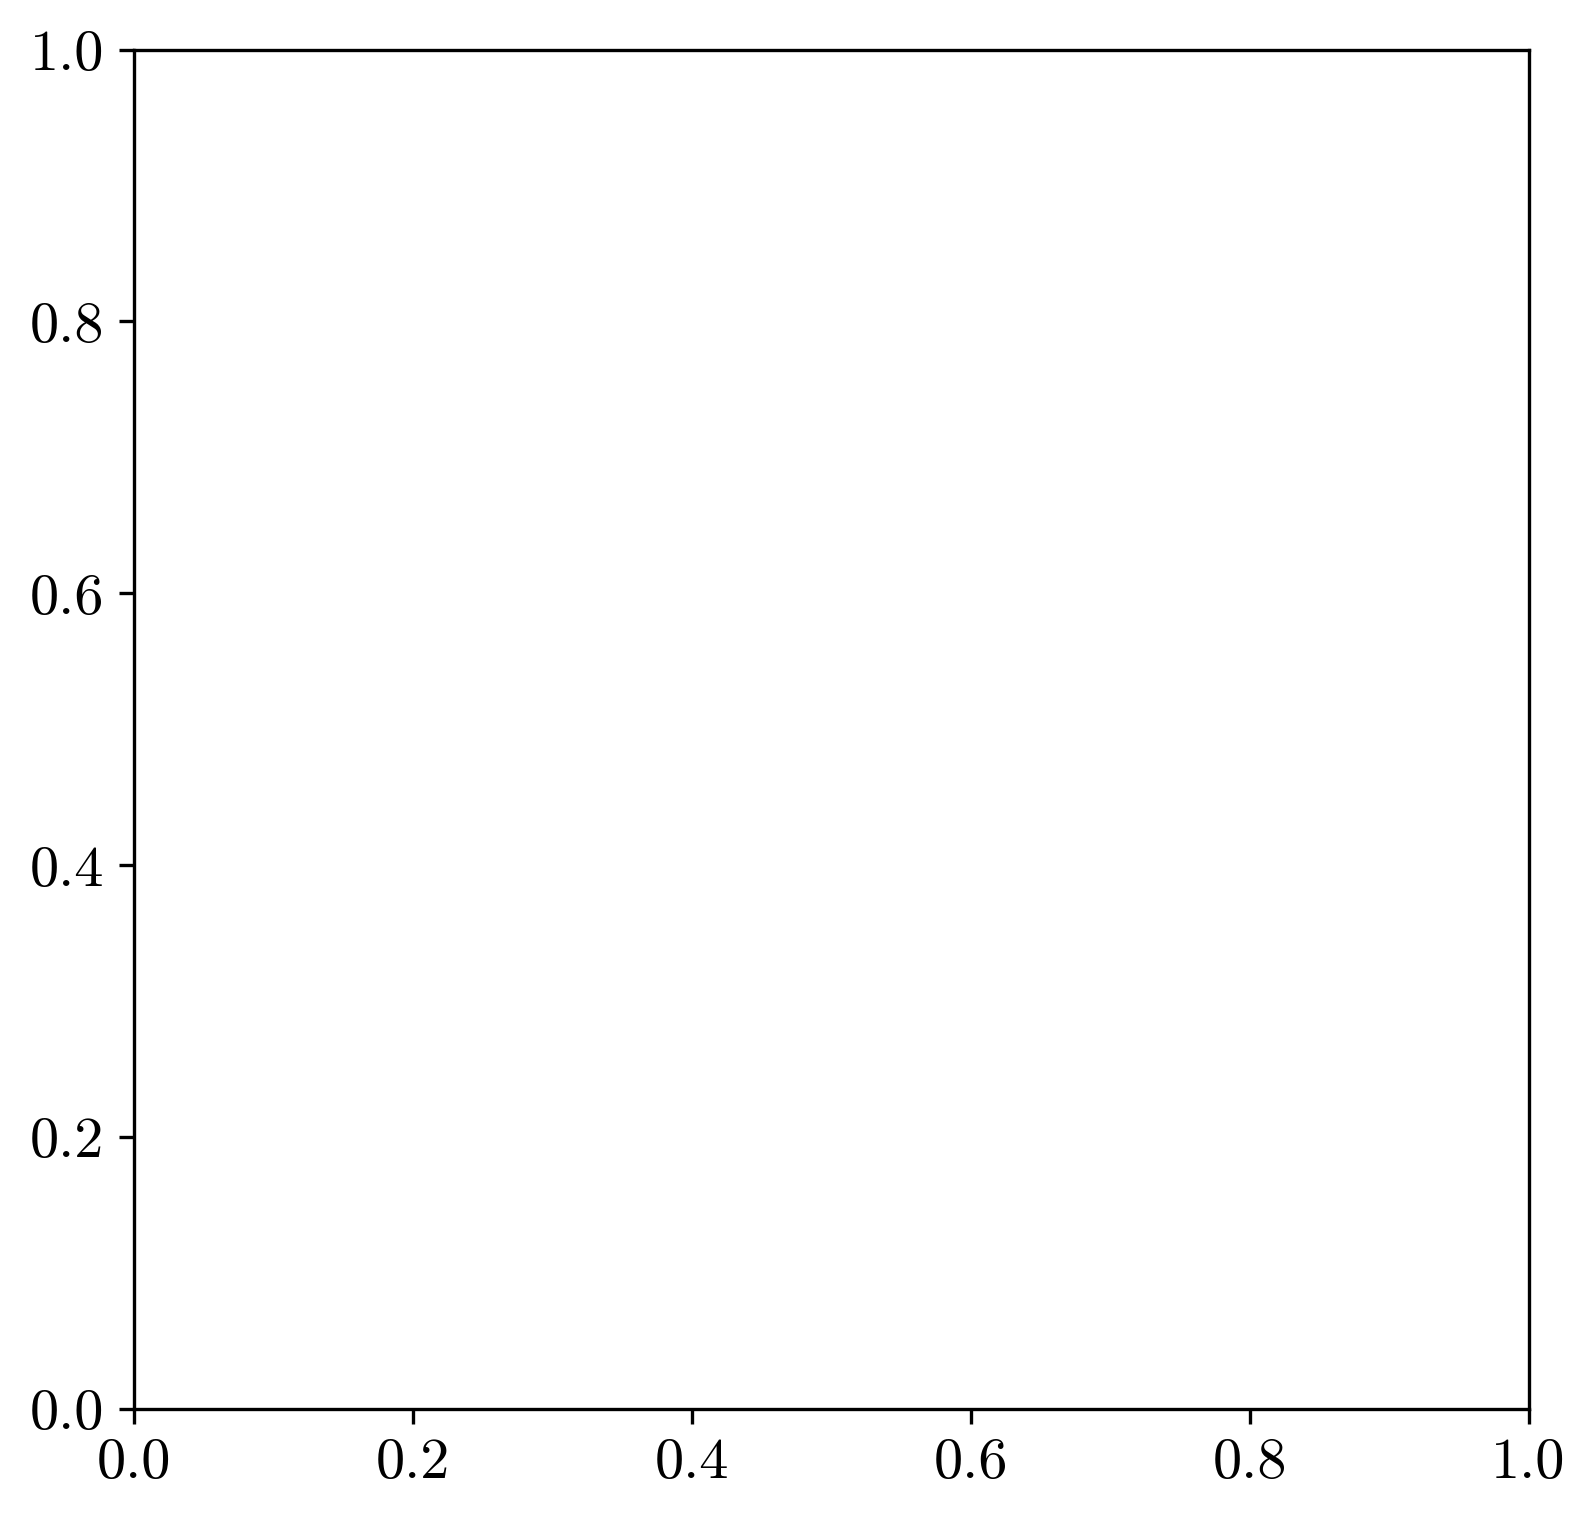

In [175]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

lines = []
xrange = [-100,120]
yrange = [-100,150]
for i in range(7):
    CS = plot_kde(ax, X_2d, predict_label, xrange, yrange, 1000, i, f'C{i}')
    lines.append(CS.collections[0])

ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.legend(lines, name_list, loc='lower right')
ax.text(.05,.92, 'Simulated Jet t-SNE Embedding',transform=ax.transAxes)    

#ax.set_title('t-SNE Embedding')    
#fig.savefig(f'../figures/paper_JHEP/t-SNE_SimulatedJet_ContourPlot.png')    
#fig.savefig(f'../figures/paper_JHEP/t-SNE_SimulatedJet_ContourPlot.pdf')

In [59]:
namelist = name_list

In [60]:
namelist

['QCD', '2p25', '2p170', '3p25', '3p170', '4p170', '4p400']

In [61]:
colorlist = ['C0','C1','C2','C3','C4','C5','C6']

In [62]:
def plot_circle_and_fill_hist(embedding, npoints, extrafeats, label, ax_i, ax_j1, ax_j2, ax_j3, center, radius, color, whichlabel):
    bins = np.linspace(0,1,26)
    circle1 = Circle(center, radius, color=color, alpha=0.35)
    diff = embedding - np.tile(np.array(center), (npoints,1))
    dist = np.sqrt(np.sum(diff*diff, axis =1))
    indices = np.where(dist<radius)
    selected_feats = extrafeats[indices[0]]
    labelselected = label[indices[0]]
    ax_i.add_patch(circle1)
    
    #ax_j1.hist(selected_feats[:,8],density=True,alpha=0.3, label='original mixture',color='grey',bins=bins)
    for i in whichlabel:
        print(i, selected_feats[labelselected==i,-1].shape)
        if namelist[i] == 'QCD':
            alpha = 0.7
        else:
            alpha = 0.3
        ax_j1.hist(selected_feats[labelselected==i,8],density=True,alpha=alpha, label=f'Selected {namelist[i]}',color=colorlist[i],bins=bins)
    ax_j1.set_xlabel(r'$\tau_{43}$', fontsize=20)
    ax_j1.set_ylabel(r'Density', fontsize=20)
    ax_j1.legend(fontsize=14)
    
    #ax_j2.hist(selected_feats[:,6],density=True,alpha=0.3, label='original mixture',color='grey',bins=bins)
    for i in whichlabel:
        print(i, selected_feats[labelselected==i,-1].shape)
        if namelist[i] == 'QCD':
            alpha = 0.7
        else:
            alpha = 0.3
        ax_j2.hist(selected_feats[labelselected==i,6],density=True,alpha=alpha, label=f'Selected {namelist[i]}',color=colorlist[i],bins=bins)
    ax_j2.set_xlabel(r'$\tau_{21}$', fontsize=20)
    ax_j2.set_ylabel(r'Density', fontsize=20)
    ax_j2.legend(fontsize=14)
    
    
    #ax_j3.hist(selected_feats[:,7],density=True,alpha=0.3, label='original mixture',color='grey',bins=bins)
    for i in whichlabel:
        print(i, selected_feats[labelselected==i,-1].shape)
        if namelist[i] == 'QCD':
            alpha = 0.7
        else:
            alpha = 0.3
        ax_j3.hist(selected_feats[labelselected==i,7],density=True,alpha=alpha, label=f'Selected {namelist[i]}',color=colorlist[i],bins=bins)
    ax_j3.set_xlabel(r'$\tau_{32}$', fontsize=20)
    ax_j3.set_ylabel(r'Density', fontsize=20)
    ax_j3.legend(fontsize=14)

    return None

    

In [64]:
X_2d.shape

(28000, 2)

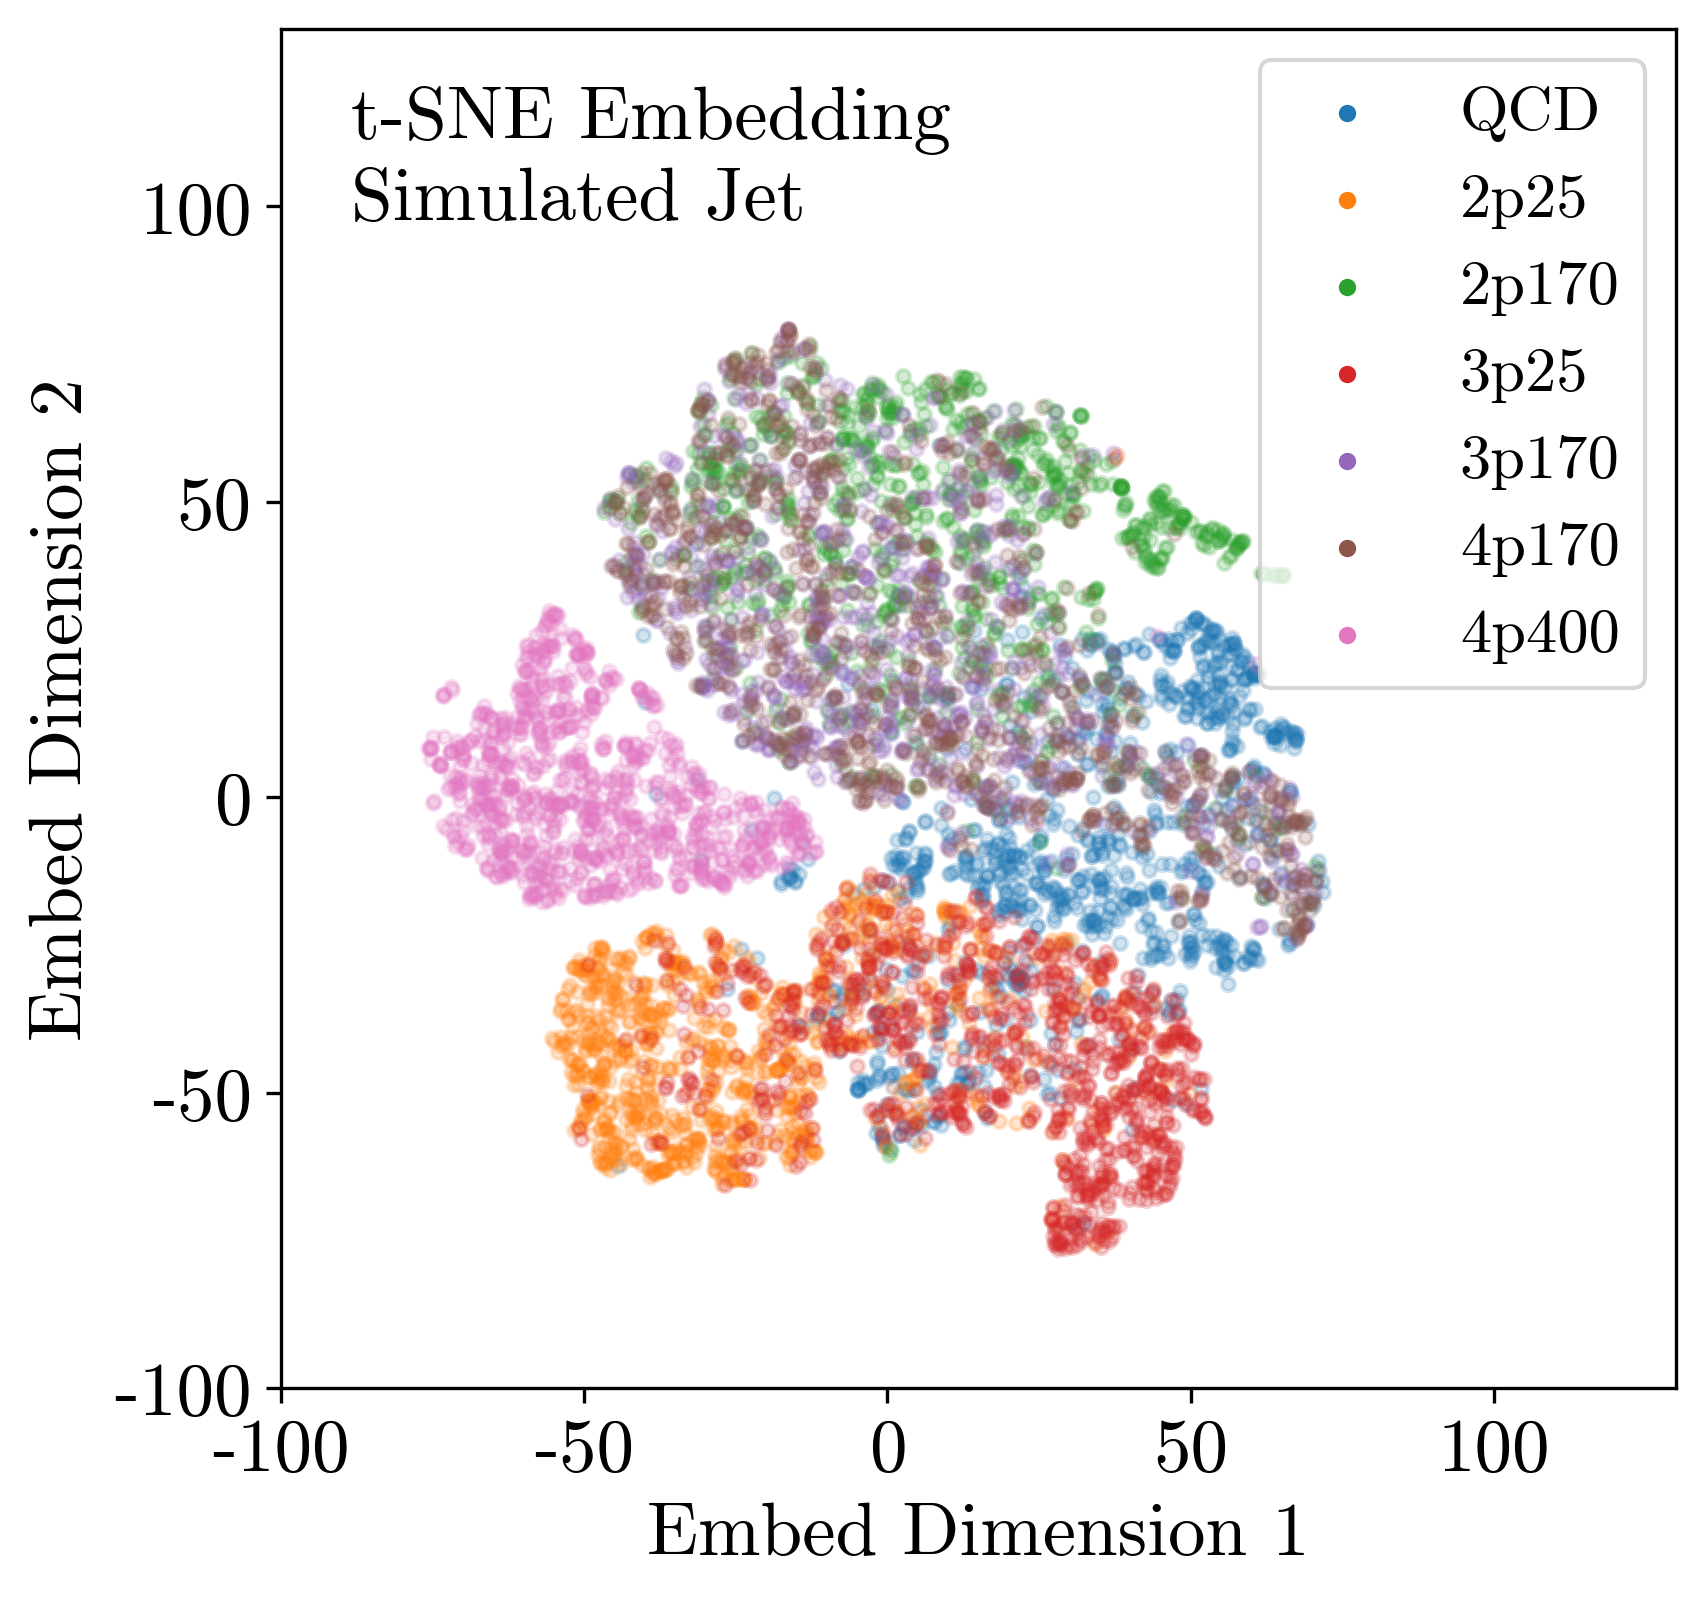

In [65]:
fig

In [68]:
extrafeats.shape

(28000, 14)

0 (1,)
4 (151,)
0 (1,)
4 (151,)
0 (1,)
4 (151,)
0 (200,)
1 (0,)
4 (149,)


/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


0 (200,)
1 (0,)
4 (149,)
0 (200,)
1 (0,)
4 (149,)
0 (80,)
1 (286,)
3 (305,)
0 (80,)
1 (286,)
3 (305,)
0 (80,)
1 (286,)
3 (305,)


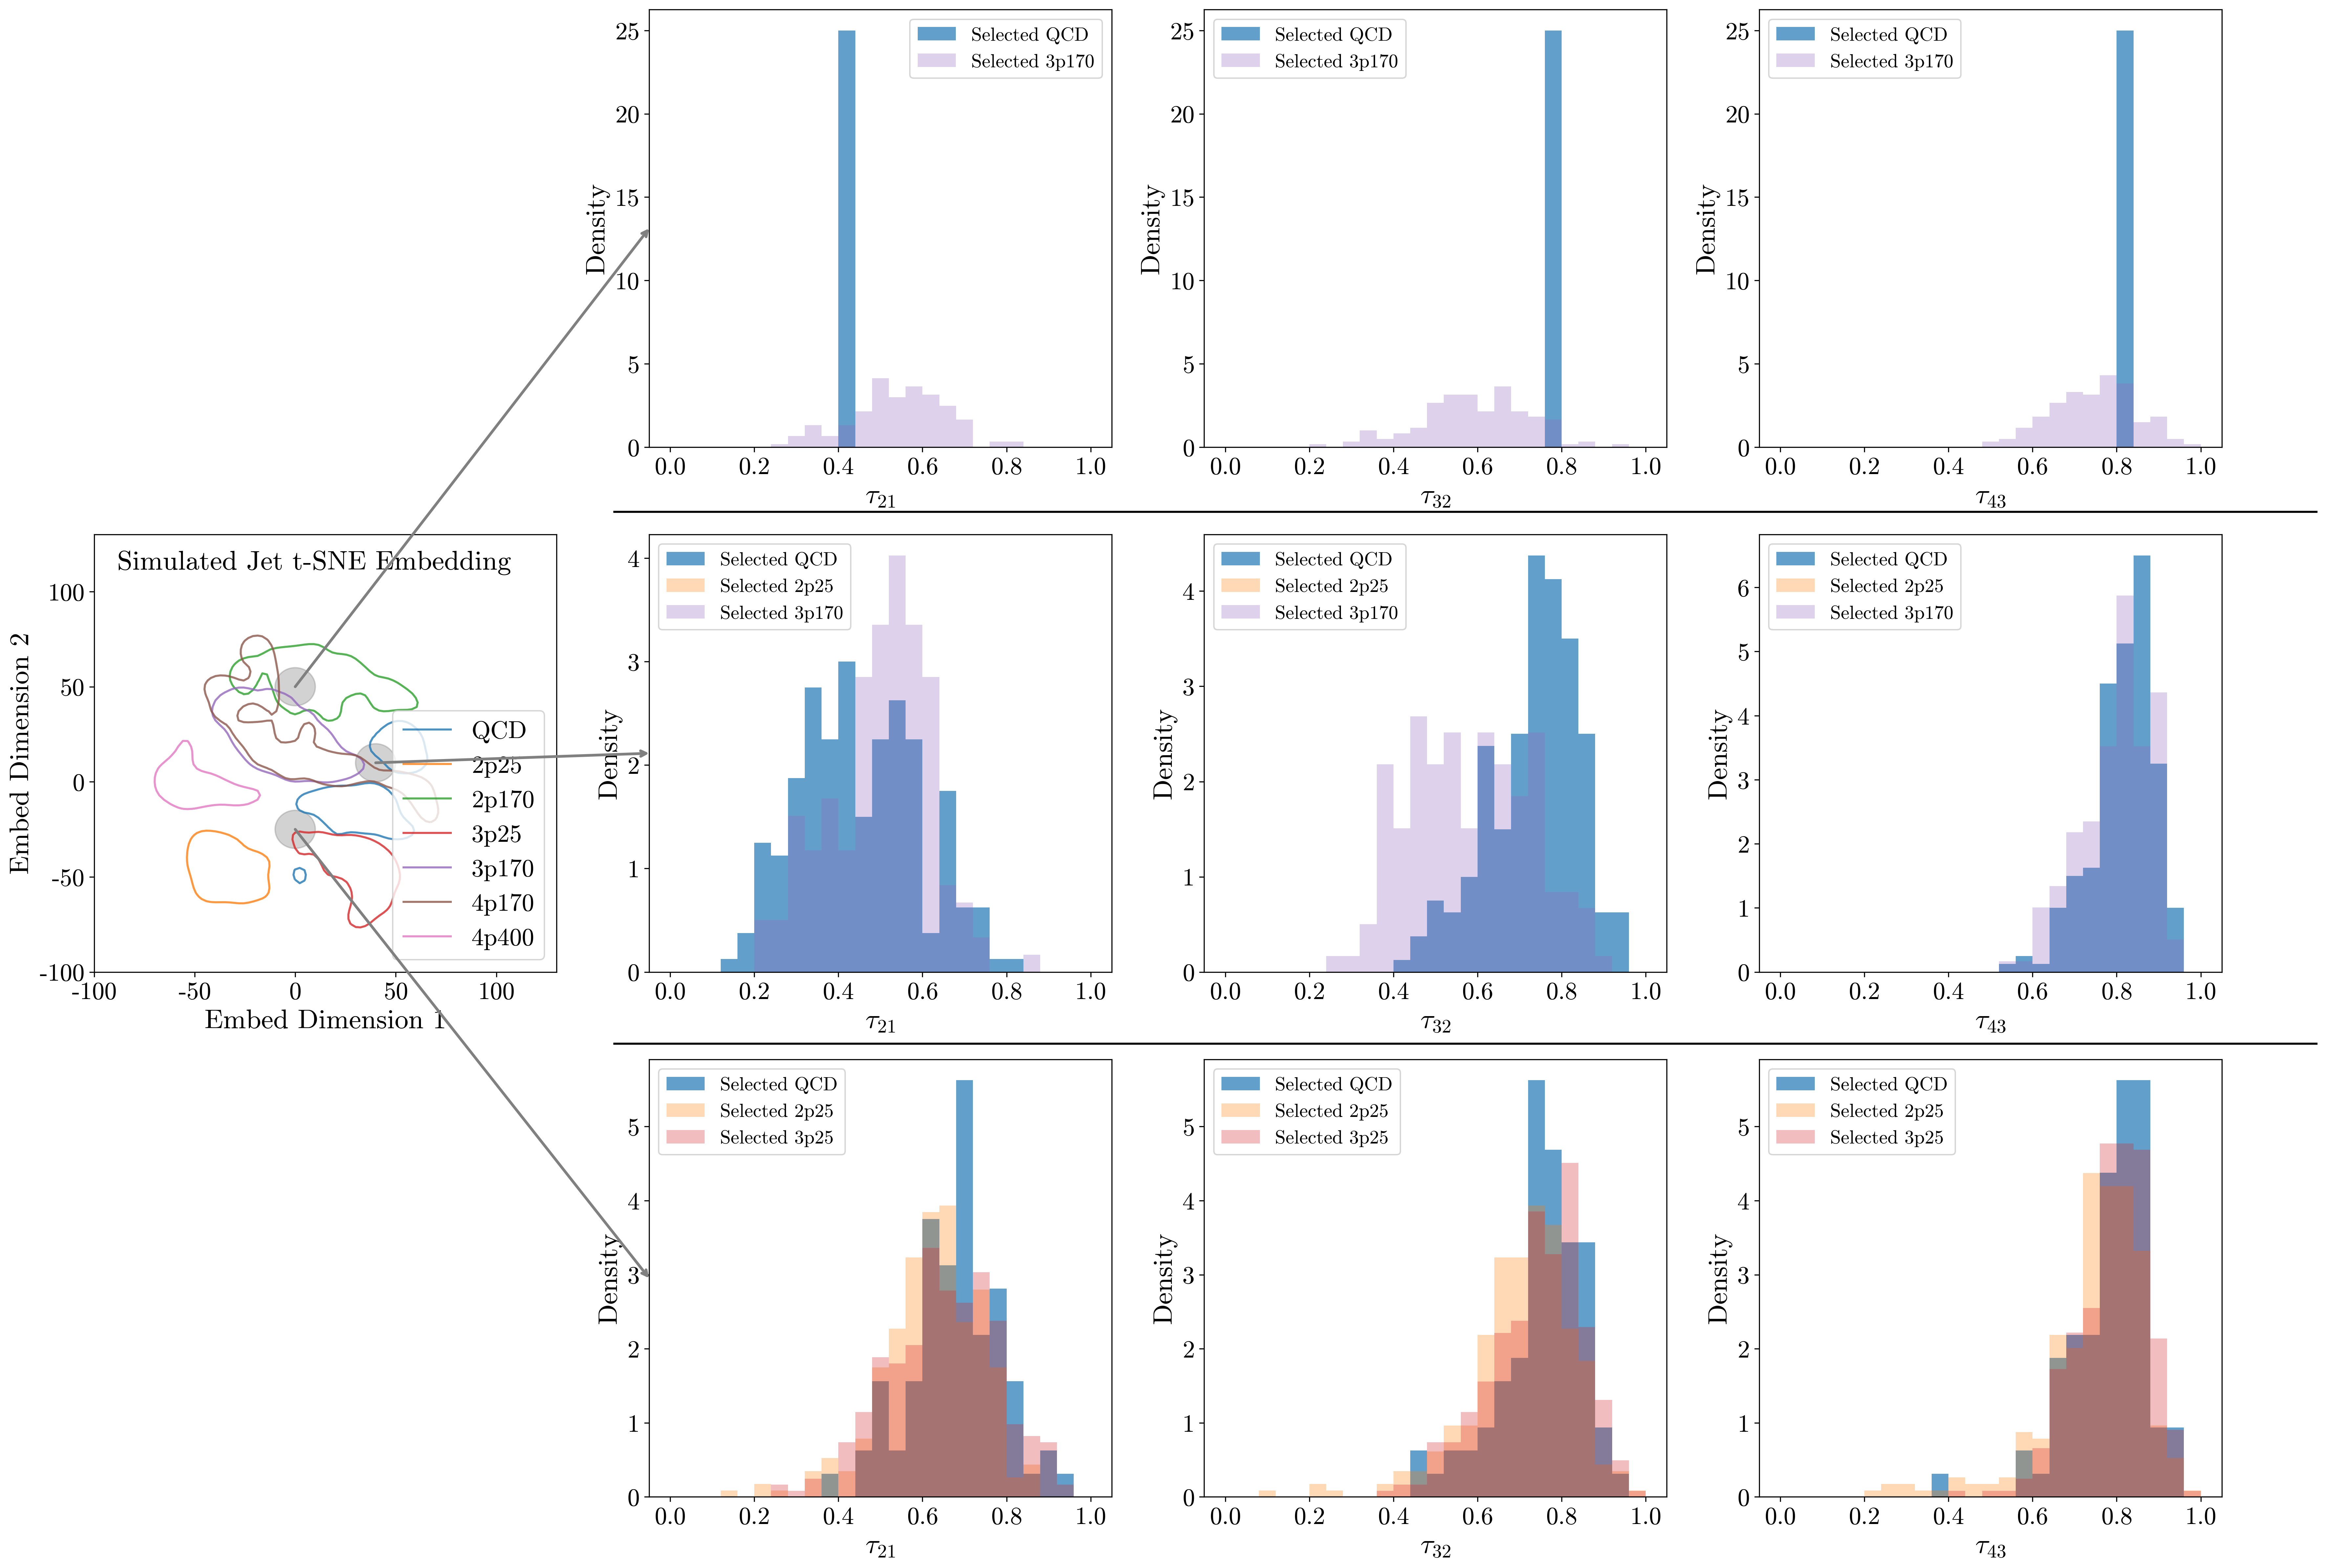

In [69]:
fig = plt.figure(constrained_layout=False, facecolor='1.',  figsize=(24,20))
gs = fig.add_gridspec(nrows=3, ncols=4, left=0.05, right=.95,
                      hspace=0.2, wspace=0.2)
ax0 = fig.add_subplot(gs[1, 0])
xrange = [-100,130]
yrange = [-100,130]

lines = []
for i in range(7):
    CS = plot_KDE_cdf_contour(ax0, X_2d, predict_label, i, xrange, yrange, 5, [0.5], f'C{i}')
    lines.append(CS.collections[0])


ax0.set_xlabel('Embed Dimension 1', fontsize=20)
ax0.set_ylabel('Embed Dimension 2', fontsize=20)
ax0.set_xlim(xrange)
ax0.set_ylim(yrange)
ax0.legend(lines, namelist, loc='lower right')
ax0.text(.05,.92, 'Simulated Jet t-SNE Embedding',transform=ax0.transAxes, fontsize=20)    


ax1 = fig.add_subplot(gs[0, 1])

ax2 = fig.add_subplot(gs[1, 1])

ax3 = fig.add_subplot(gs[2, 1])

ax4 = fig.add_subplot(gs[0, 2])

ax5 = fig.add_subplot(gs[1, 2])

ax6 = fig.add_subplot(gs[2, 2])

ax7 = fig.add_subplot(gs[0, 3])

ax8 = fig.add_subplot(gs[1, 3])

ax9 = fig.add_subplot(gs[2, 3])
plot_circle_and_fill_hist(X_2d, 28000, extrafeats, predict_label, ax0, ax7, ax1, ax4,  (0,50), 10,'grey',[0,4])
plot_circle_and_fill_hist(X_2d, 28000, extrafeats, predict_label, ax0, ax8, ax2, ax5,  (40,10), 10,'grey',[0,1,4])
plot_circle_and_fill_hist(X_2d, 28000, extrafeats, predict_label, ax0, ax9, ax3, ax6,  (0,-25), 10,'grey',[0,1,3])



con = ConnectionPatch(xyA=(0,50), xyB=(0,0.5), coordsA="data", coordsB="axes fraction",
                              axesA=ax0, axesB=ax1, color="grey", lw=2, arrowstyle='->')
fig.add_artist(con)
con = ConnectionPatch(xyA=(40,10), xyB=(0,0.5), coordsA="data", coordsB="axes fraction",
                              axesA=ax0, axesB=ax2, color="grey", lw=2, arrowstyle='->')
fig.add_artist(con)
con = ConnectionPatch(xyA=(0,-25), xyB=(0,0.5), coordsA="data", coordsB="axes fraction",
                              axesA=ax0, axesB=ax3, color="grey", lw=2, arrowstyle='->')
fig.add_artist(con)

ys = [0.355,0.625]
for y in ys:
    line = plt.Line2D([0.27,0.99],[y,y], transform=fig.transFigure, color="black")
    fig.add_artist(line)

In [84]:
fig.savefig(f'../figures/paper_JHEP/t-SNE_WhatIsLearned.png')    
fig.savefig(f'../figures/paper_JHEP/t-SNE_WhatIsLearned.pdf')

In [22]:
results.shape

(21000, 54)

In [23]:
fit = umap.UMAP(random_state=0)
#%time u = fit.fit_transform(results[:,:48])
%time u = fit.fit_transform(results)

CPU times: user 48.5 s, sys: 267 ms, total: 48.8 s
Wall time: 43.6 s


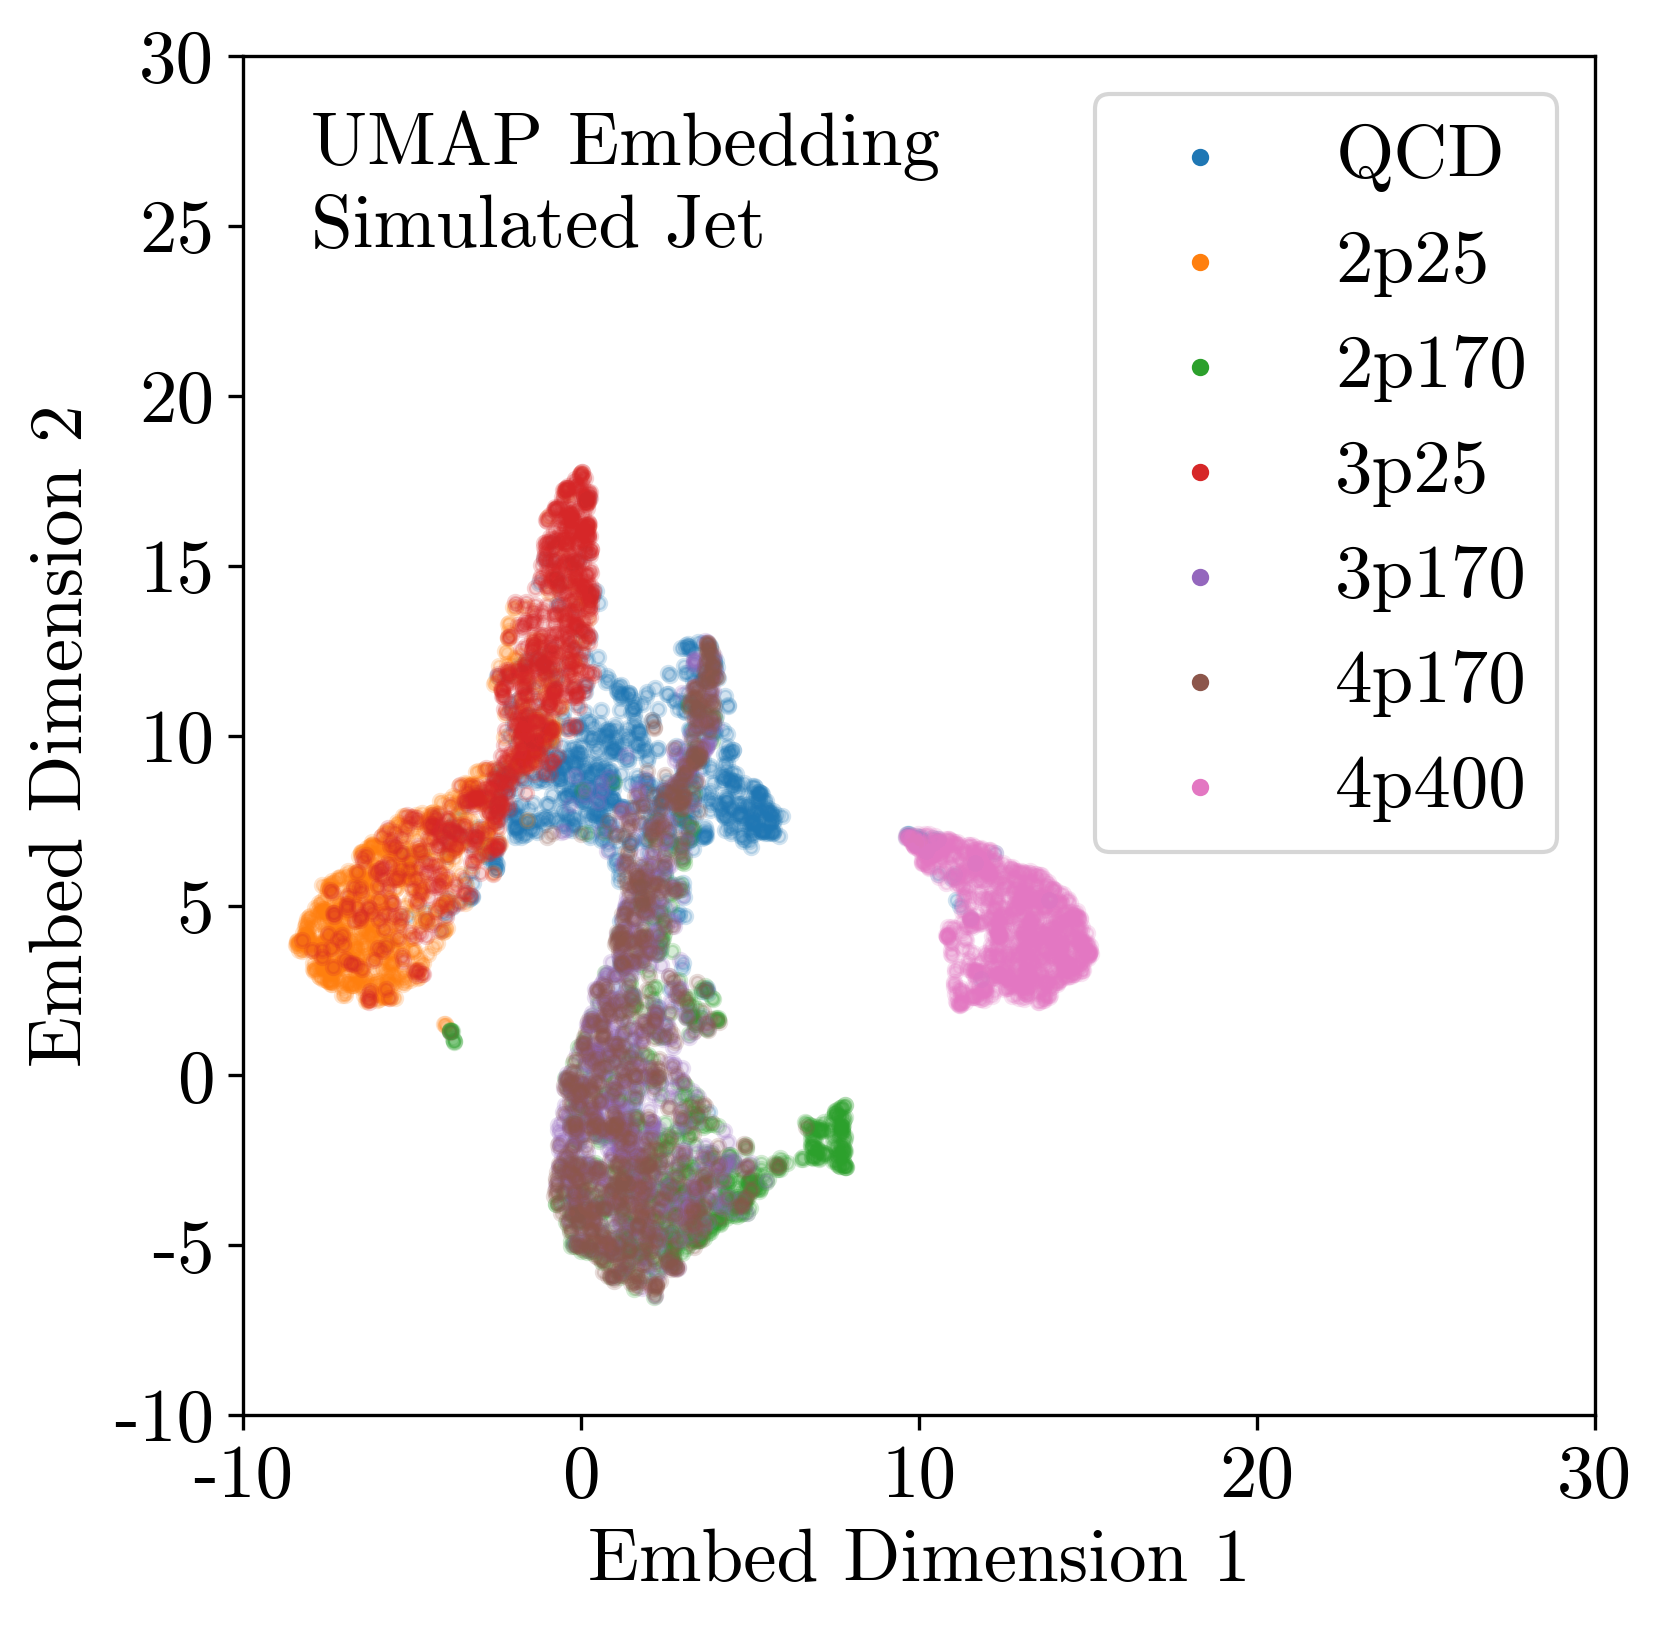

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i in range(7):
    ax.scatter(u[predict_label==i][:1000,0],u[predict_label==i][:1000,1],s=10,alpha=0.20,label=name_list[i])

ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim([-10,30])
ax.set_ylim([-10,30])
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.subplots_adjust(left=0.17)
ax.text(.05,.92, 'UMAP Embedding',transform=ax.transAxes)    
ax.text(.05,.86, 'Simulated Jet',transform=ax.transAxes)        
fig.savefig(f'../figures/paper_JHEP/UMAP_SimulatedJet_ScatterPlot.png')    
fig.savefig(f'../figures/paper_JHEP/UMAP_SimulatedJet_ScatterPlot.pdf')

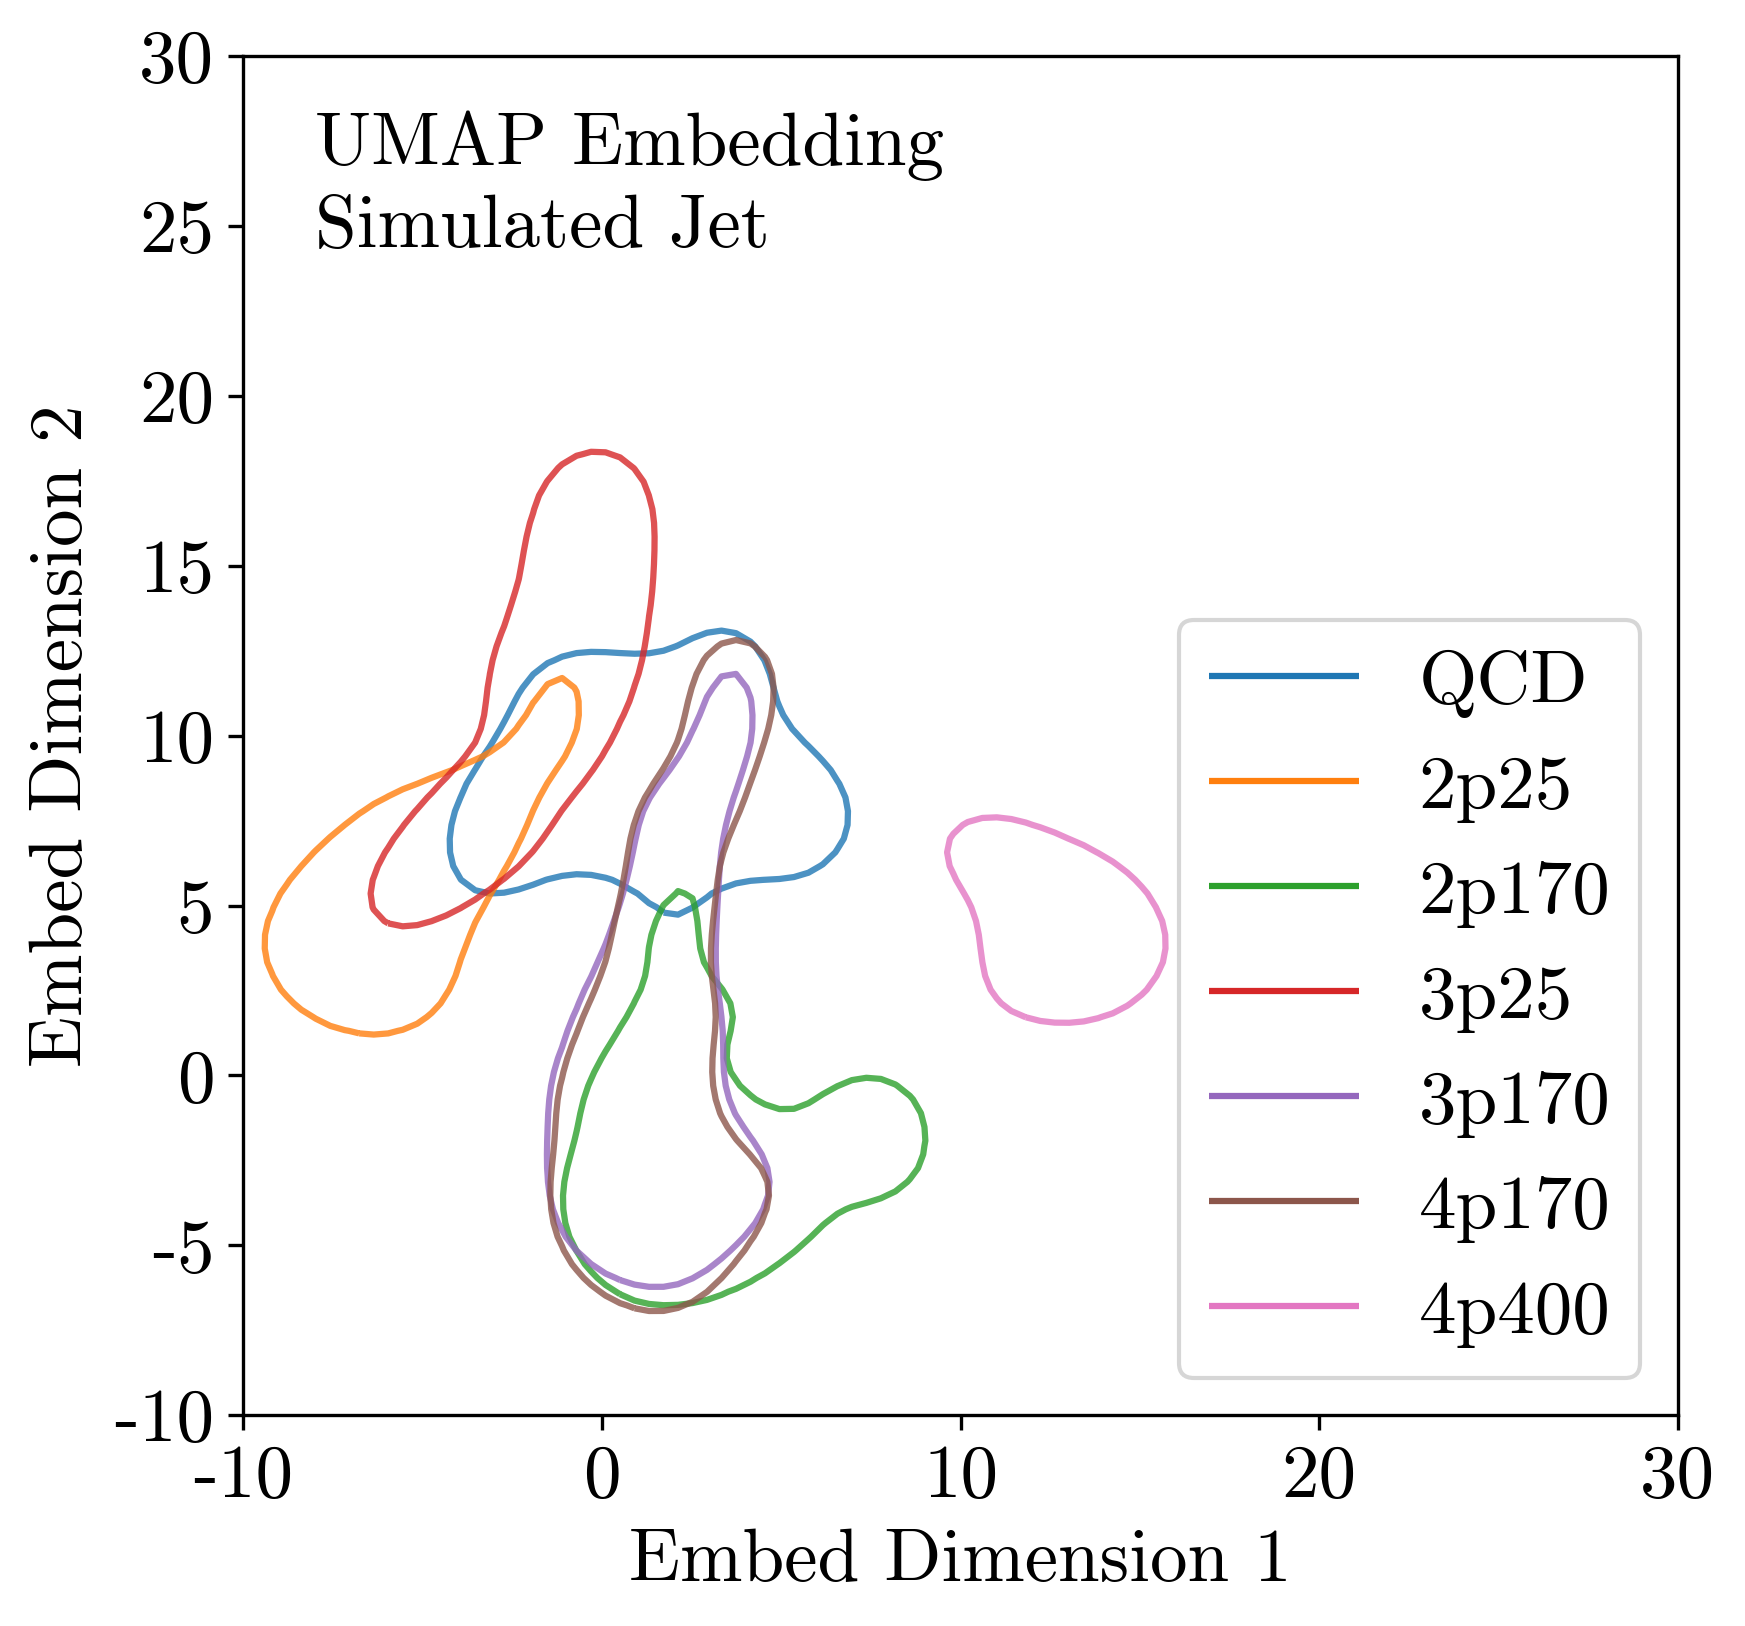

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
lines = []
xrange = [-10,30]
yrange = [-10,30]
for i in range(0,7):
    CS = plot_KDE_cdf_contour(ax, u, predict_label, i, xrange, yrange, 1, [0.8], f'C{i}')
    lines.append(CS.collections[0])


ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim(xrange)
ax.set_ylim(yrange)
leg = ax.legend(lines, name_list, loc='lower right')

for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
ax.text(.05,.92, 'UMAP Embedding',transform=ax.transAxes)    
ax.text(.05,.86, 'Simulated Jet',transform=ax.transAxes)        

fig.savefig(f'../figures/paper_JHEP/UMAP_SimulatedJet_ContourPlot.png')    
fig.savefig(f'../figures/paper_JHEP/UMAP_SimulatedJet_ContourPlot.pdf')    
    
    










0 (161,)
1 (34,)
3 (108,)
4 (63,)
5 (31,)
6 (98,)
0 (161,)
1 (34,)
3 (108,)
4 (63,)
5 (31,)
6 (98,)
0 (161,)
1 (34,)
3 (108,)
4 (63,)
5 (31,)
6 (98,)
0 (221,)
2 (73,)
3 (203,)
4 (155,)
5 (118,)
6 (46,)
0 (221,)
2 (73,)
3 (203,)
4 (155,)
5 (118,)
6 (46,)
0 (221,)
2 (73,)
3 (203,)
4 (155,)
5 (118,)
6 (46,)
0 (137,)
1 (286,)
2 (70,)
3 (425,)
4 (195,)
5 (213,)
0 (137,)
1 (286,)
2 (70,)
3 (425,)
4 (195,)
5 (213,)
0 (137,)
1 (286,)
2 (70,)
3 (425,)
4 (195,)
5 (213,)


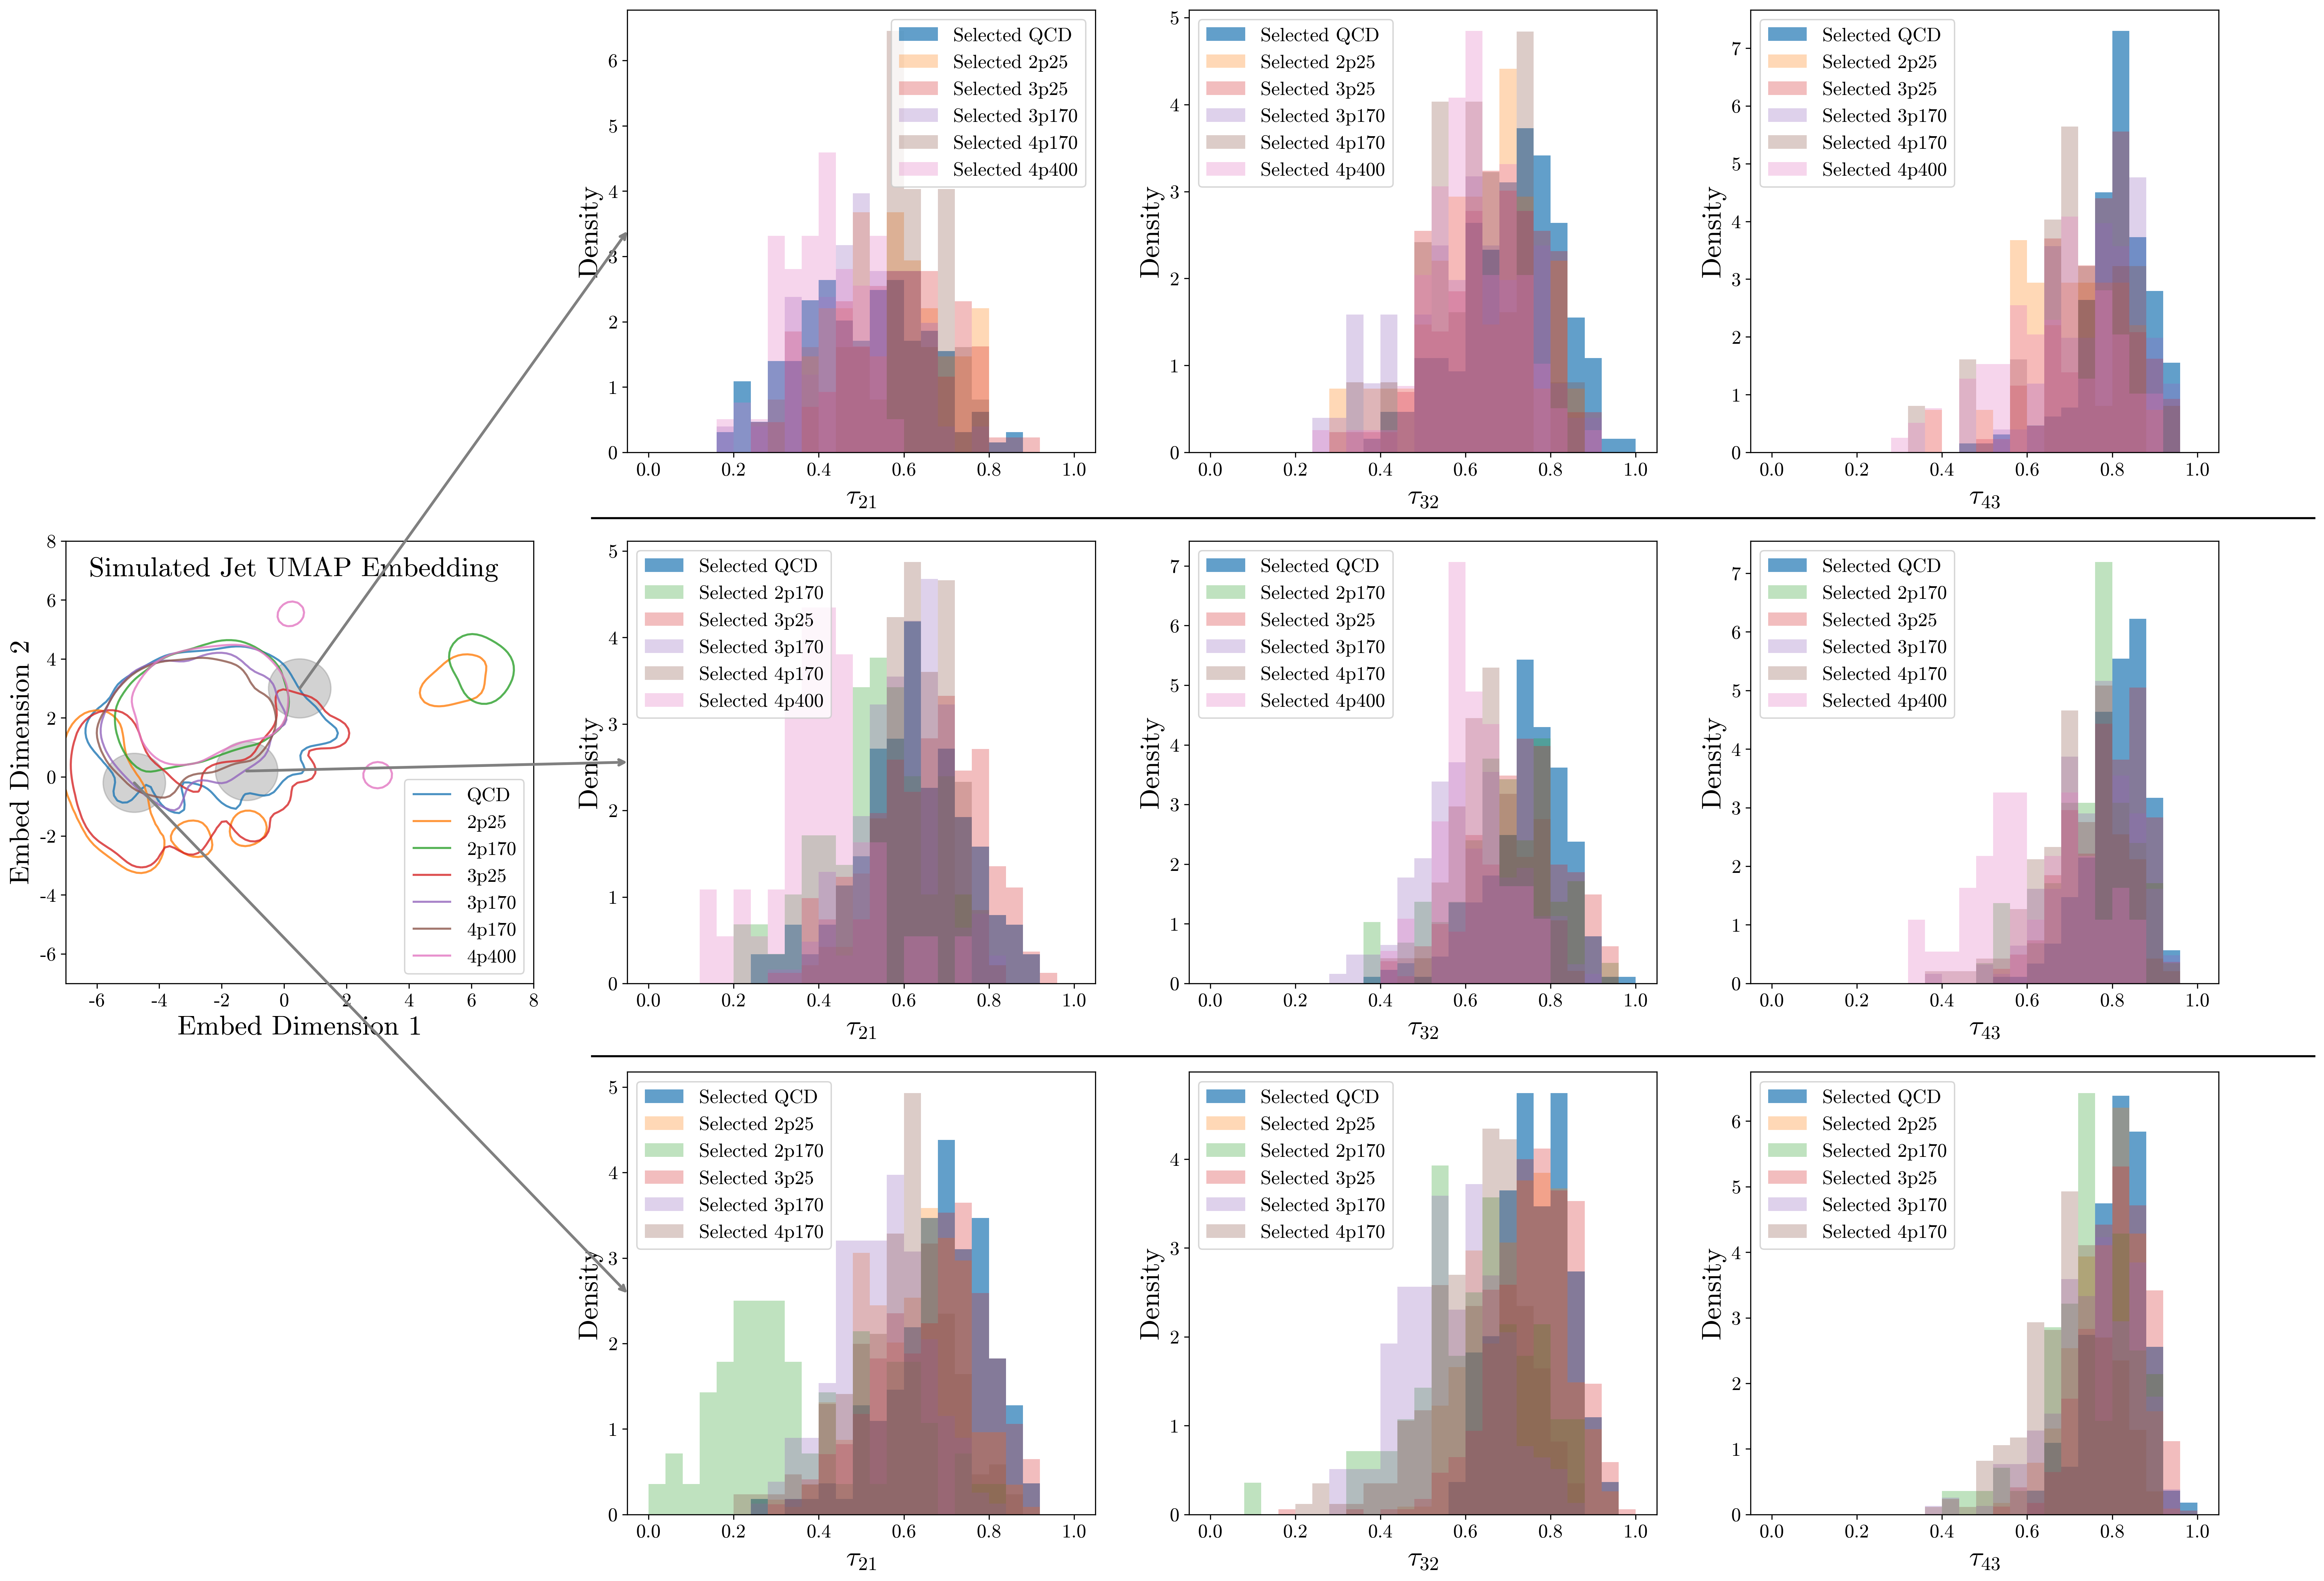

In [81]:
fig = plt.figure(constrained_layout=False, facecolor='1.',  figsize=(24,20))
gs = fig.add_gridspec(nrows=3, ncols=4, left=0.05, right=.95,
                      hspace=0.2, wspace=0.2)
ax0 = fig.add_subplot(gs[1, 0])

xrange = [-7,8]
yrange = [-7,8]

lines = []
for i in range(7):
    CS = plot_KDE_cdf_contour(ax0, u, sliced_label, i, xrange, yrange, 0.4, [0.8], f'C{i}')
    lines.append(CS.collections[0])


ax0.set_xlabel('Embed Dimension 1', fontsize=20)
ax0.set_ylabel('Embed Dimension 2', fontsize=20)
ax0.set_xlim(xrange)
ax0.set_ylim(yrange)
ax0.legend(lines, namelist, loc='lower right')
ax0.text(.05,.92, 'Simulated Jet UMAP Embedding',transform=ax0.transAxes, fontsize=20)    


ax1 = fig.add_subplot(gs[0, 1])

ax2 = fig.add_subplot(gs[1, 1])

ax3 = fig.add_subplot(gs[2, 1])

ax4 = fig.add_subplot(gs[0, 2])

ax5 = fig.add_subplot(gs[1, 2])

ax6 = fig.add_subplot(gs[2, 2])

ax7 = fig.add_subplot(gs[0, 3])

ax8 = fig.add_subplot(gs[1, 3])

ax9 = fig.add_subplot(gs[2, 3])
plot_circle_and_fill_hist(u, 21000, sliced_feats, sliced_label, ax0, ax7, ax1, ax4,  (.5,3), 1,'grey',[0,1,3,4,5,6])
plot_circle_and_fill_hist(u, 21000, sliced_feats, sliced_label, ax0, ax8, ax2, ax5,  (-1.2,.2), 1,'grey',[0,2,3, 4,5, 6])
plot_circle_and_fill_hist(u, 21000, sliced_feats, sliced_label, ax0, ax9, ax3, ax6,  (-4.8,-.2), 1,'grey',[0,1,2,3, 4,5])



con = ConnectionPatch(xyA=(.5,3), xyB=(0,0.5), coordsA="data", coordsB="axes fraction",
                              axesA=ax0, axesB=ax1, color="grey", lw=2, arrowstyle='->')
fig.add_artist(con)
con = ConnectionPatch(xyA= (-1.2,.2), xyB=(0,0.5), coordsA="data", coordsB="axes fraction",
                              axesA=ax0, axesB=ax2, color="grey", lw=2, arrowstyle='->')
fig.add_artist(con)
con = ConnectionPatch(xyA=(-4.8,-.2), xyB=(0,0.5), coordsA="data", coordsB="axes fraction",
                              axesA=ax0, axesB=ax3, color="grey", lw=2, arrowstyle='->')
fig.add_artist(con)

ys = [0.355,0.625]
for y in ys:
    line = plt.Line2D([0.27,0.99],[y,y], transform=fig.transFigure, color="black")
    fig.add_artist(line)

In [82]:
fig.savefig(f'../figures/paper_JHEP/UMAP_WhatIsLearned.png')    
fig.savefig(f'../figures/paper_JHEP/UMAP_WhatIsLearned.pdf')

1.0 1.9962017659478416e-104
1.0 2.4801180903429234e-40
1.0 1.652244208500187e-51
1.0 2.18252661399157e-67
1.0 3.700066800459951e-52
1.0 1.9154471022027065e-45
1.0 6.290258049700703e-64


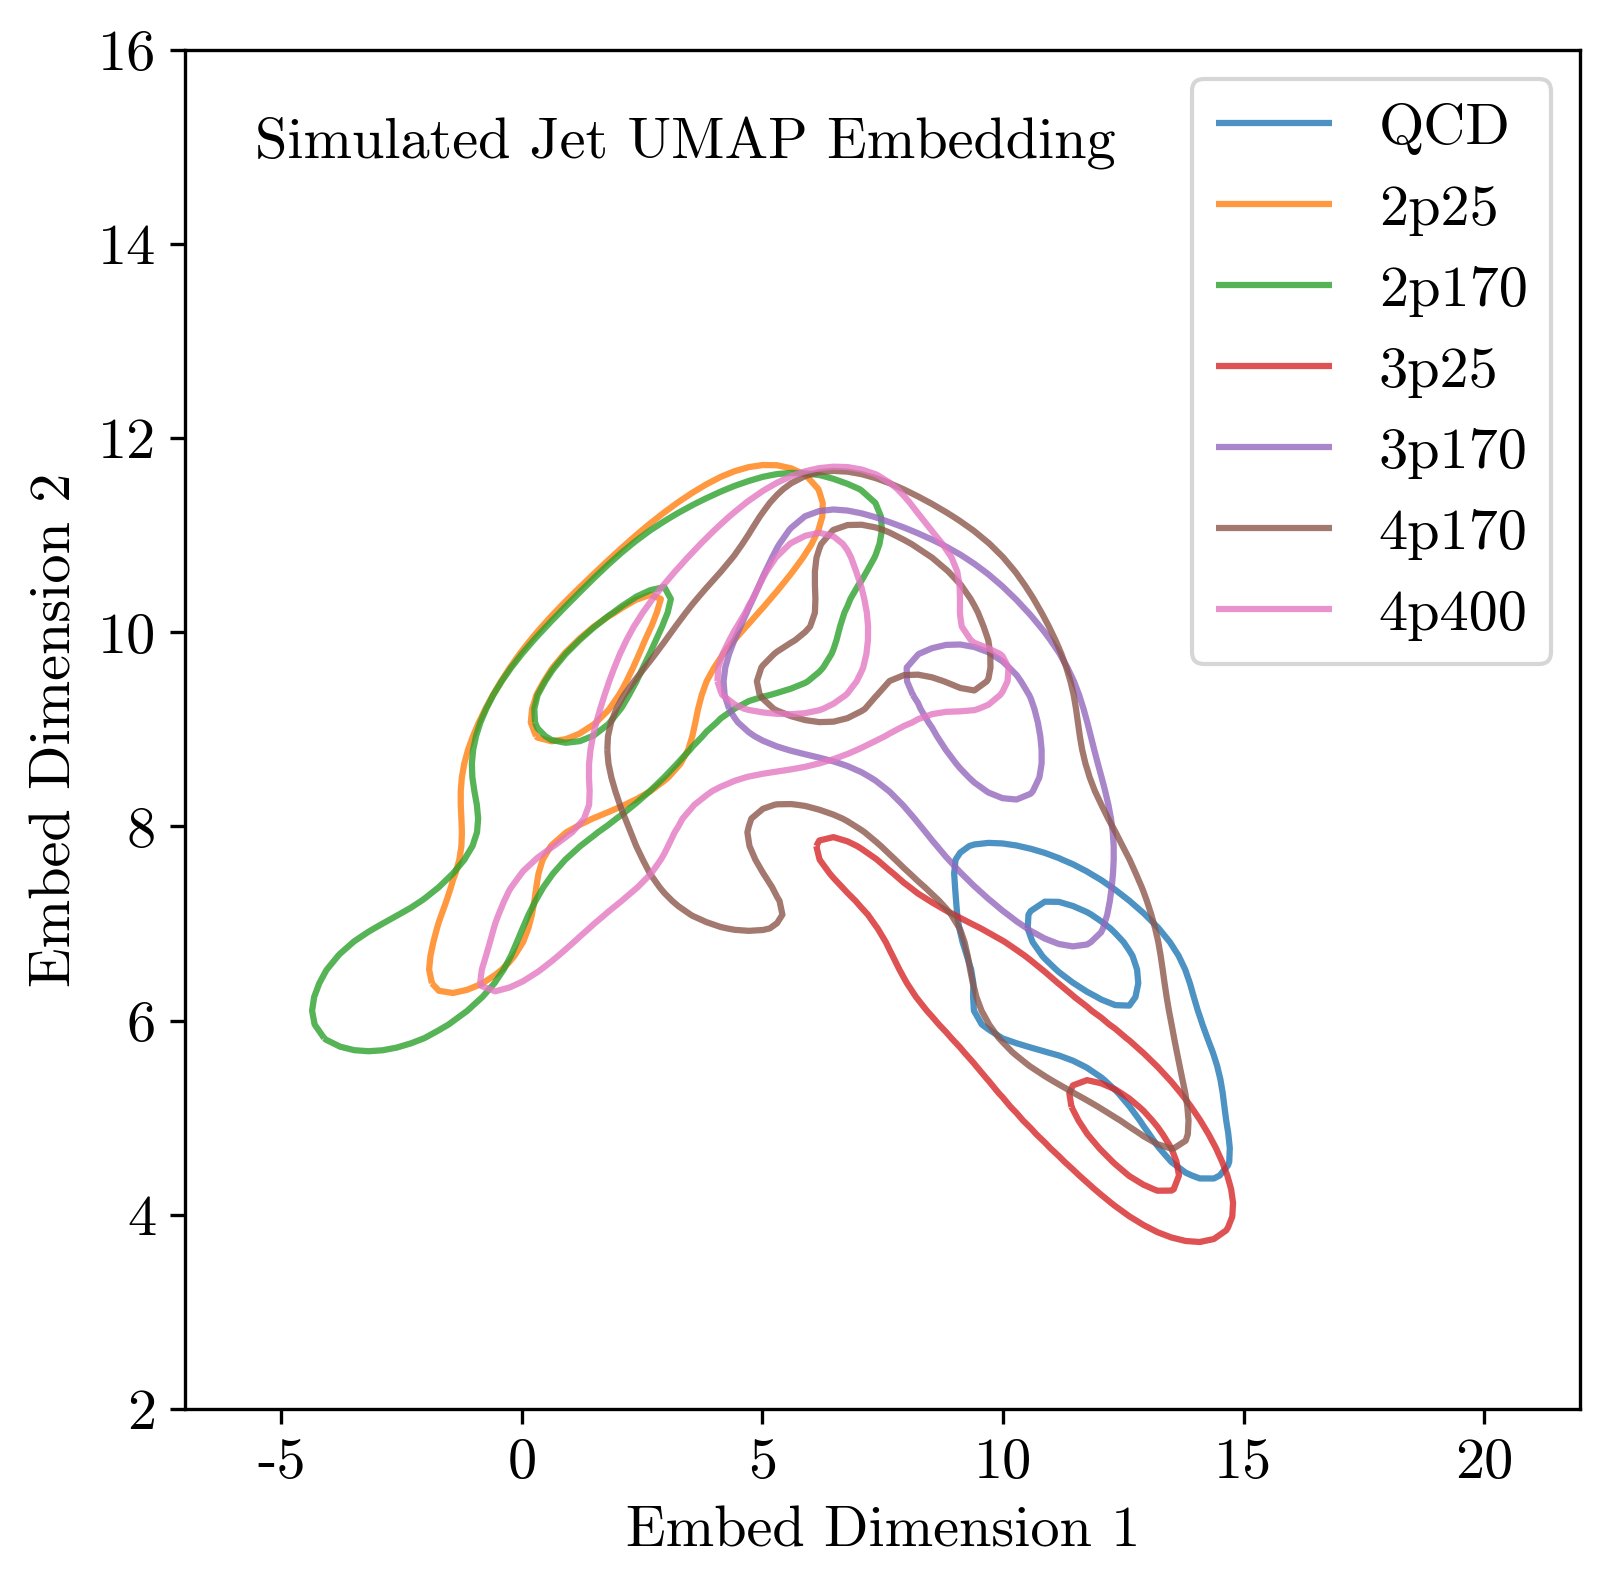

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

lines = []
xrange = [-7,22]
yrange = [2,16]
for i in range(7):
    CS = plot_kde(ax, u, predict_label, xrange, yrange, 1000, i, f'C{i}')
    lines.append(CS.collections[0])

ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.legend(lines, name_list)
ax.text(.05,.92, 'Simulated Jet UMAP Embedding',transform=ax.transAxes)    
fig.savefig(f'../figures/paper_JHEP/UMAP_SimulatedJet_ContourPlot.png')    
fig.savefig(f'../figures/paper_JHEP/UMAP_SimulatedJet_ContourPlot.pdf')

In [ ]:
model = ManifoldEmbedder.load_from_checkpoint("./simulatedtoyjets_checkpoints/Transformer-paper-v0-checkpoint-epoch=01-val_loss=0.55.ckpt")
model.eval()